This notebook is for making changes to figures for presenting shuffle analysis.

It works together with scripts "deploy_shuffle_clustering.py" and "run_shuffle_clustering.py" which are in vba repo, to generate shuffled datasets, coclustering matrices and labels for each type of shuffle.

To do:
* remove probability from plots, plot size diff only. Done
* set not matched cluster size to 0 (not nan). Done
* invert colors of SSE heatmaps. Done
* add statistics to cluster size differences. Done but needs checking
* plot area and depth info using bars. not done
* Plot commonly shuffled clusters



In [166]:
import os
import numpy as np

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import seaborn as sns

sns.set_context('notebook', font_scale=1, rc={'lines.markeredgewidth': 1})



In [167]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [169]:
import visual_behavior.visualization.utils as utils
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_clustering as glm_clust

palette_experience = utils.get_experience_level_colors()
palette_cre = utils.get_cre_line_colors()

In [170]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:

# # load experiments table
experiments_table = loading.get_platform_paper_experiment_table()
# # limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)


3921 cells in matched cells table


### Set up variables and stuff

In [225]:
figsizes = [(20,7), (10,7), (20,7)]
threshold=0.16

In [8]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [9]:
# set params for saving
folder = '220820_presentation'
file_dir = '220627_shuffle_test/files'

In [10]:
base_dir = r'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [11]:
# create folder to load and save to
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

#### Load original feature matrix,, meta data and cluster labels

In [26]:
filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(base_dir,file_dir, filename), key='df')

In [285]:
filename = 'cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5'
df_meta = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [14]:
filename = 'cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5'
original_cluster_labels = pd.read_hdf(os.path.join(base_dir, file_dir, filename))
original_cluster_labels = original_cluster_labels.reset_index(drop=True)
original_cluster_labels

,labels,cell_specimen_id,cre_line,cluster_id
0,3,1086492406,Vip-IRES-Cre,3
1,2,1086492307,Vip-IRES-Cre,2
2,4,1086492221,Vip-IRES-Cre,4
3,4,1086492174,Vip-IRES-Cre,4
4,2,1086491936,Vip-IRES-Cre,2
...,...,...,...,...
3916,1,1120113340,Slc17a7-IRES2-Cre,10
3917,7,1120112555,Slc17a7-IRES2-Cre,3
3918,2,1120111975,Slc17a7-IRES2-Cre,5
3919,0,1120111711,Slc17a7-IRES2-Cre,1


In [15]:
# trying to fix mismatch of clusters 4 and 5

indices = original_cluster_labels[original_cluster_labels['cre_line']=='Slc17a7-IRES2-Cre'].index.values
original_cluster_labels.loc[indices, 'cluster_id']=original_cluster_labels[original_cluster_labels['cre_line']=='Slc17a7-IRES2-Cre']['cluster_id'].replace([4,5], [5,4])
original_cluster_labels

,labels,cell_specimen_id,cre_line,cluster_id
0,3,1086492406,Vip-IRES-Cre,3
1,2,1086492307,Vip-IRES-Cre,2
2,4,1086492221,Vip-IRES-Cre,4
3,4,1086492174,Vip-IRES-Cre,4
4,2,1086491936,Vip-IRES-Cre,2
...,...,...,...,...
3916,1,1120113340,Slc17a7-IRES2-Cre,10
3917,7,1120112555,Slc17a7-IRES2-Cre,3
3918,2,1120111975,Slc17a7-IRES2-Cre,4
3919,0,1120111711,Slc17a7-IRES2-Cre,1


In [27]:
cre_lines = np.sort(df_meta['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = df_meta[df_meta['cre_line']==cre_line].index.values
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

#### compute mean dropout scores for original data

In [17]:
cre_mean_dropout_scores = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df)
    
    
    # This is a bandaid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    # if cre_line == 'Slc17a7-IRES2-Cre':
    #     print('changing stuff')
    #     mean_dropout_scores=mean_dropout_scores.rename(columns= {4:5,5:4})
    #     mean_dropout_scores = mean_dropout_scores.reindex(sorted(mean_dropout_scores), axis=1)
    cre_mean_dropout_scores[cre_line] = mean_dropout_scores

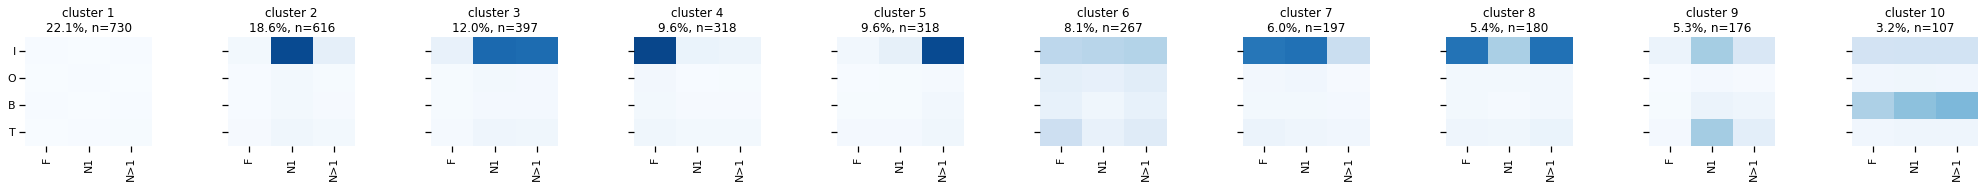

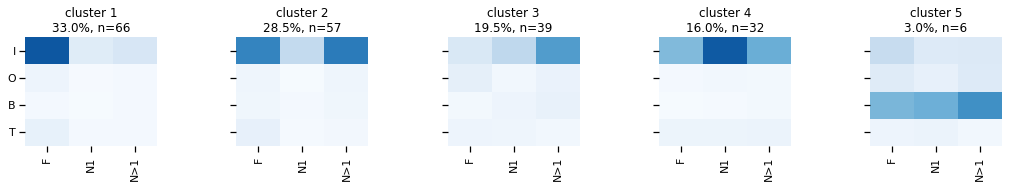

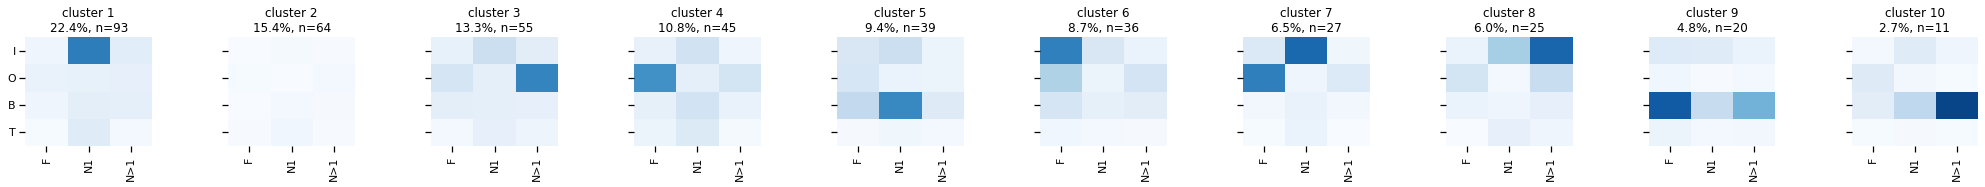

In [18]:
# plot original clusters
sort_order = {}
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix='_original_tmp',
                                )


### Load shuffled datasets into one dictionary

In [19]:
shuffle_types = ['experience', 'experience_within_cell','full_experience']
# randomize 150 samples of shuffled data
# n_boots = np.random.randint(0, 500, 150)
n_boots = np.arange(500)

In [20]:
shuffle_type_dict = {}
shuffle_type_dict['experience']='cell ID'
shuffle_type_dict['experience_within_cell']='exp labels'
shuffle_type_dict['full_experience']='both'


#### load cluster labels for each dataset into one dictionary

In [21]:
%%time
shuffle_type_labels = {}
for shuffle_type in shuffle_types:
    cre_labels_shuffled = {}
    for cre_line in cre_lines:
        nb_labels_shuffled = {}                       
        for n, n_boot in enumerate(n_boots):
            nb_filename ='{}_{}_nb{}_cluster_labels.h5'.format(cre_line, shuffle_type, n_boot) 
            full_filename = os.path.join(base_dir, file_dir, nb_filename)
            nb_labels_shuffled[n] = pd.read_hdf(full_filename, key = 'clustered_df')
        
        #print(shuffle_type, cre_line, index)
        cre_labels_shuffled[cre_line] = nb_labels_shuffled
    shuffle_type_labels[shuffle_type] = cre_labels_shuffled
    

Wall time: 5min 43s


#### load shuffled dropout scores dfs

In [22]:
%%time
# this takes a few minutes
shuffle_type_df = {}
for shuffle_type in shuffle_types:
    cre_df_shuffled = {}
    for cre_line in cre_lines:
        nb_shuffled = {}
        for n, n_boot in enumerate(n_boots):
            nb_filename ='{}_{}_nb{}.h5'.format(cre_line, shuffle_type, n_boot)
            nb_shuffled[n] = pd.read_hdf(os.path.join(base_dir, file_dir, nb_filename), key = 'df')
         
        cre_df_shuffled[cre_line] = nb_shuffled
    shuffle_type_df[shuffle_type] = cre_df_shuffled

Wall time: 4min 20s


#### compute mean dropout scores for shuffled dfs


In [29]:
shuffle_type_mean_dropout_scores = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        for n, n_boot in enumerate(n_boots):
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n]
            mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df)
            nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores
        cre_mean_dropout_scores_shuffled[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores[shuffle_type] = cre_mean_dropout_scores_shuffled

In [37]:
### this takes a lot of time so run it at your own risk
### plot shuffled clusters in a row per shuffle
# for shuffle_type in shuffle_types[::-1]:
#     for cre_line in cre_lines[::-1]:
#         for n, n_boot in enumerate(n_boots[:50]):
#             feature_matrix = shuffle_type_df[shuffle_type][cre_line][n]
#             cluster_df = shuffle_type_labels[shuffle_type][cre_line][n].set_index('cell_specimen_id')
#             sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
#             vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
#                                    sort_order=sort_order, rename_clusters=True, save_dir=save_dir, folder='shuffled_plots', 
#                                         suffix='_nb'+str(n_boot)+'_'+shuffle_type)
#             plt.close('all')

### compute SSE

In [205]:
shuffle_type_SSE = {}
for shuffle_type in shuffle_types:
    cre_SSE = {}
    for cre_line in cre_lines:
        nb_sse = {}
        original_df = cre_mean_dropout_scores[cre_line]
        for n, n_boot in enumerate(n_boots):
            shuffled_df = shuffle_type_mean_dropout_scores[shuffle_type][cre_line][n]
            sse = vba_clust.compute_SSE(original_df, shuffled_df)
            nb_sse[n] = sse
        cre_SSE[cre_line] = nb_sse
    shuffle_type_SSE[shuffle_type] = cre_SSE
        

#### get cluster mapping

In [226]:
# create a map dictionary of ogriginal clusters : shuffled clusters
print(f'Using threshold of {threshold}')
shuffle_type_SSE_mapping = {}
for shuffle_type in shuffle_types:
    cre_SSE_mapping = {}
    for cre_line in cre_lines:
        nb_sse_mapping = {}
        nb_matrix = shuffle_type_SSE[shuffle_type][cre_line]
        cluster_mapping = vba_clust.get_cluster_mapping(nb_matrix, threshold = threshold) 
        cre_SSE_mapping[cre_line] = cluster_mapping
    shuffle_type_SSE_mapping[shuffle_type] = cre_SSE_mapping



Using threshold of 0.16


In [207]:
nb=11
shuffle_type_SSE_mapping[shuffle_type][cre_lines[0]][nb]

{1: 1, 2: 4, 3: 5, 4: 2, 5: 3, 6: 7, 7: 8, 8: 6, 9: 7, 10: -1}

<AxesSubplot:>

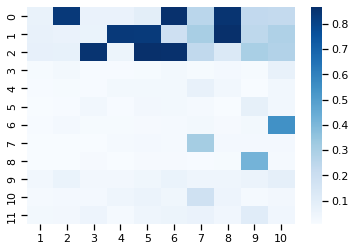

In [208]:
# plot one example of Exc shuffle to spot check that mapping is correct
tmp = shuffle_type_mean_dropout_scores[shuffle_type][cre_lines[0]][nb]
sns.heatmap(tmp, cmap='Blues')

In [227]:
# collects matrices of SSE maps
shuffle_type_SSE_values = {}
for shuffle_type in shuffle_types:
    cre_SSE_values = {}
    for cre_line in cre_lines:
        nb_matrix = shuffle_type_SSE[shuffle_type][cre_line]
        cluster_mapping_SSE = vba_clust.get_mapped_SSE_values(nb_matrix, threshold = threshold)
        cre_SSE_values[cre_line] = cluster_mapping_SSE
    shuffle_type_SSE_values[shuffle_type] = cre_SSE_values


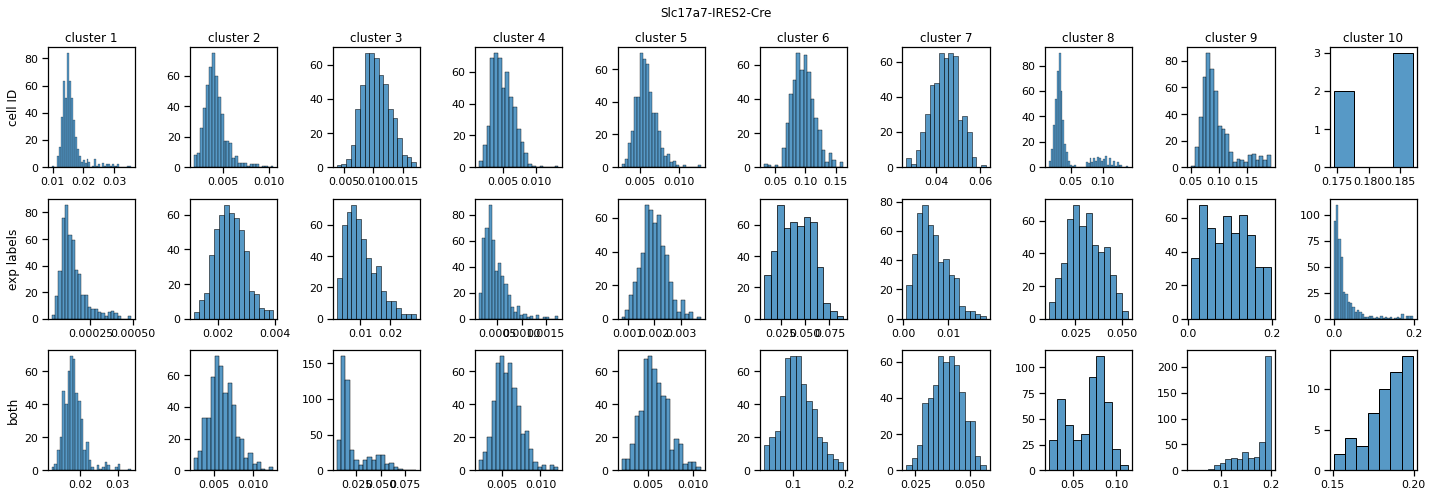

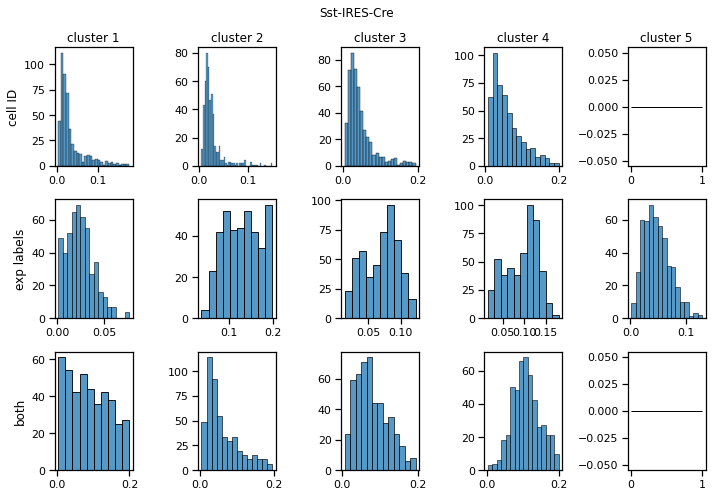

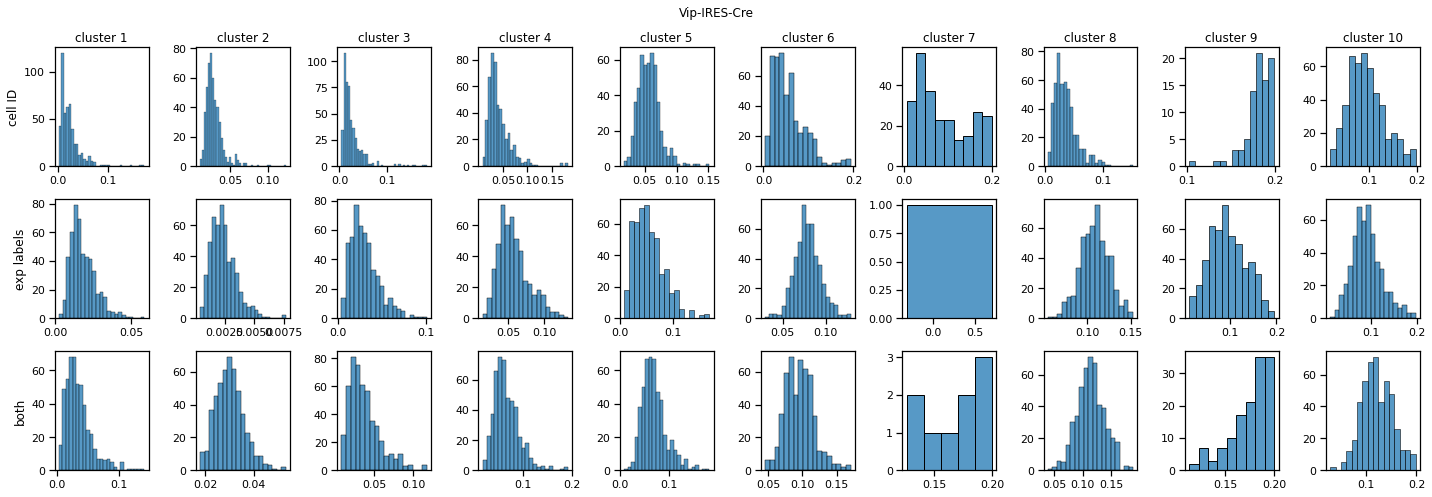

In [210]:
# plot histograms of SSE values for matched clusters for each cluster id 
# this plot helps to see which threshold to choose
for c,cre_line in enumerate(cre_lines):
    fig = plt.figure(figsize=figsizes[c], )
    ax_i =1
    for s,shuffle_type in enumerate(shuffle_types):
        tmp = shuffle_type_SSE_values[shuffle_type][cre_line]
        cluster_ids = tmp.keys()
        
        for i,cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(3, len(cluster_ids), ax_i, )
            ax = sns.histplot(tmp[cluster_id], ax=ax, )
            if s == 0:
                ax.set_title(f'cluster {cluster_id}')
                
            if cluster_id !=1:
                ax.set_ylabel('')
            else:
                ax.set_ylabel(shuffle_type_dict[shuffle_type])
            ax_i=ax_i+1
            #ax.set_xlim([0, threshold])
    fig.suptitle(cre_line)
        
    plt.tight_layout()
    utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder=f'SSE_hist_by_cluster_{threshold}',
                          fig_title=f'SSE_hist_{cre_line}')
    
# this code block plots one row at a time (for easier editing if needed)
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
#         tmp = shuffle_type_SSE_values[shuffle_type][cre_line]
#         cluster_ids = tmp.keys()
#         fig, ax = plt.subplots(1,len(cluster_ids), figsize = (15,3), sharey = "row")
#         for i,cluster_id in enumerate(cluster_ids):
#             ax[i] = sns.histplot(tmp[cluster_id], ax=ax[i], )
#             ax[i].set_title(f'cluster {cluster_id}')
#             #ax[i].set_xlim([0, threshold])
#         plt.suptitle(shuffle_type + ' ' + cre_line)
#         plt.tight_layout()
#         utils.save_figure(fig, figsize = (15,3), save_dir=save_dir, folder='SSE_by_cluster',
#                           fig_title=f'SSE_hist_{cre_line}_{shuffle_type}_{threshold}')

#### Individual iteration SSE matrix plots

In [59]:

# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
#         for n, n_boot in enumerate(n_boots[:50]):
#             tmp = shuffle_type_SSE[shuffle_type][cre_line][n_boot]
#             labels=np.arange(1,len(tmp)+1)
#             fig, ax = plt.subplots(1,1,figsize = (10,10))
#             ax=sns.heatmap(tmp, annot=True, cmap = 'Greys', 
#                            yticklabels=labels, xticklabels=labels,ax=ax)
#             plt.suptitle(cre_line[:3]+ ' ' + shuffle_type + ' ' + str(n_boot))
#             plt.tight_layout()
#             utils.save_figure(fig, figsize = (10,10), save_dir=save_dir, folder='SSE', 
#                       fig_title=f'SSE_matrix{cre_line[:3]}_nb{n_boot}_{shuffle_type}')
#             plt.close('all')

### Plot cluster heatmaps with SSE matrix together

In [49]:
#create unstacked mean dropout scores for each cluster for plotting
cre_original_clusters_unstacked = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df, stacked=False)
    # This is a bandaid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    # if cre_line == 'Slc17a7-IRES2-Cre':
    #     # reverse 4 and 5 cluster again. 
    #     mean_dropout_scores[100] = mean_dropout_scores.pop(4)
    #     mean_dropout_scores[4] = mean_dropout_scores.pop(5)
    #     mean_dropout_scores[5] = mean_dropout_scores.pop(100)
    cre_original_clusters_unstacked[cre_line] = mean_dropout_scores
            

<AxesSubplot:xlabel='experience_level'>

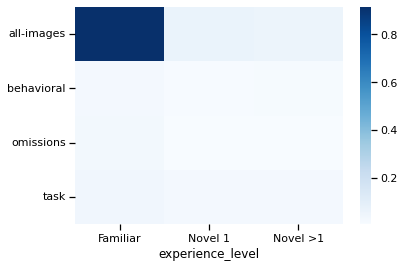

In [51]:
# plot cluster 4 to make sure its correct ('familiar')
sns.heatmap(cre_original_clusters_unstacked[cre_lines[0]][4], cmap='Blues')

#### plotting aligned clusters into one folder
This will make it easier to scroll through plots and to make sure that all matched clusters are well matched


In [53]:
#create unstacked mean dropout scores for each cluster for plotting
shuffle_type_mean_dropout_scores_unstacked = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled_unstacked = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        for n,n_boot in enumerate(n_boots):
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n]
            mean_dropout_scores_unstacked = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df, stacked=False)
            nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores_unstacked
        cre_mean_dropout_scores_shuffled_unstacked[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores_unstacked[shuffle_type] = cre_mean_dropout_scores_shuffled_unstacked

<AxesSubplot:xlabel='experience_level'>

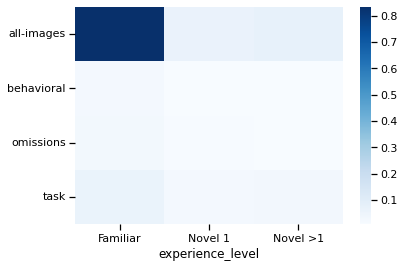

In [57]:
#### spot check one iteration of Excitatory cells, make sure that cluster 4 was matched correctly
nb_match_ids = shuffle_type_SSE_mapping[shuffle_type][cre_lines[0]][nb]
tmp = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_lines[0]][nb][nb_match_ids[4]]
sns.heatmap(tmp, cmap='Blues')

In [72]:

# # This takes forever, so commenting it out unless it's needed
# # plot
# vmin = 0
# cmap = 'Blues'
# # loop through the thresholds first
# for threshold in thresholds:
#     shuffle_type_SSE_mapping = threshold_SSE_mapping[threshold]
#     #shuffle_types = shuffle_type_SSE_mapping.keys()
    
#     # loop through shuffle types
#     for shuffle_type in shuffle_types[::-1]:
#         #cre_lines = shuffle_type_SSE_mapping[shuffle_type].keys()
        
#         # loop through cre lines
#         for cre_line in cre_lines[::-1]:
#             # n_boots = shuffle_type_SSE_mapping[shuffle_type][cre_line].keys()
#             # n_boots is already specified. You cant select a handful when using dictionary keys so commenting it out
            
#             # plot only a few examples for speed
#             for n_boot in n_boots[100:130]:

#                 cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot].keys()
#                 for cluster_id in cluster_ids:
#                     matched_cluster_id = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot][cluster_id]
#                     if matched_cluster_id !=-1:
#                         dropout_scores = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n_boot][matched_cluster_id]

#                         # plot cluster
#                         fig, ax = plt.subplots()    
#                         sns.heatmap(dropout_scores,cmap = cmap, vmin=vmin, vmax=1, ax = ax,)
#                         ax.set_title(f'cre_line:{cre_line}, clust_id:{cluster_id}, nb:{n_boot}')

#                         # save
#                         this_folder = os.path.join(shuffle_type+str(threshold), cre_line[:3], f'cluster_{cluster_id}')
#                         this_dir = os.path.join(save_dir, this_folder)
#                         if not os.path.exists(this_dir):
#                             os.makedirs(this_dir)    
#                         plt.tight_layout()
#                         figname = 'nb_{}.png'.format(n_boot)
#                         fig.savefig(os.path.join(this_dir, figname))

#                         plt.close('all')

#                 # plot all unmatched clusters into one folder
#                 # all matched cluster ids
#                 matched_cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot].values()
#                 for cluster_id in cluster_ids:
#                     # if it is not in matched cluster ids, plot and save into unmatched folder
#                     if cluster_id not in matched_cluster_ids:
#                         dropout_scores = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n_boot][cluster_id]
#                         # plot cluster
#                         fig, ax = plt.subplots()    
#                         sns.heatmap(dropout_scores,cmap = cmap, vmin=vmin, vmax=1, ax = ax,)
#                         ax.set_title(f'cre_line:{cre_line}, clust_id:{cluster_id}, nb:{n_boot}')

#                         # save
#                         this_folder = os.path.join(shuffle_type+str(threshold), cre_line[:3], 'unmatched')
#                         this_dir = os.path.join(save_dir, this_folder)
#                         if not os.path.exists(this_dir):
#                             os.makedirs(this_dir)    
#                         plt.tight_layout()
#                         figname = 'nb_{}_cluster_id_{}.png'.format(n_boot, cluster_id)
#                         fig.savefig(os.path.join(this_dir, figname))

#                         plt.close('all')


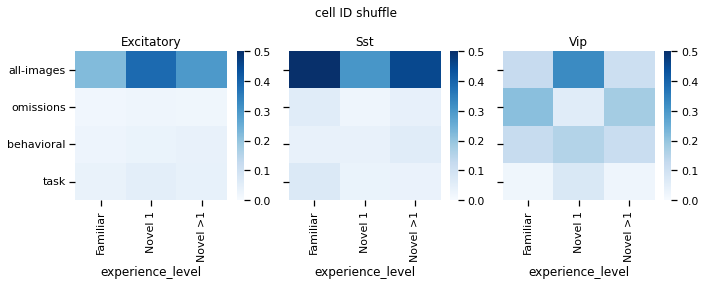

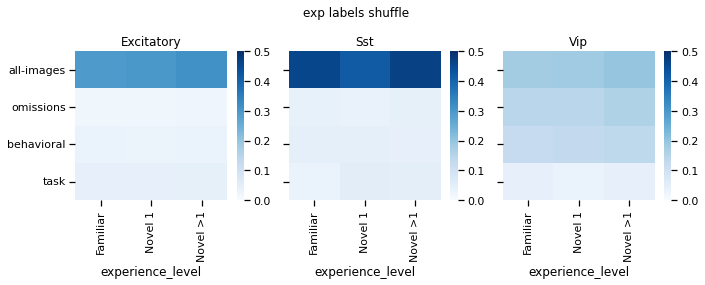

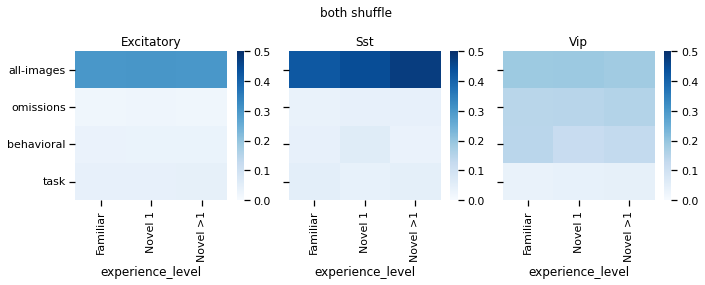

In [228]:
### pot mean of shuffled dropout scores regardless of clusters.
figsize = (10,4)
for shuffle_type in shuffle_types:
    fig, ax = plt.subplots(1,3, figsize = figsize, sharey='row')
    for c, cre_line in enumerate(cre_lines):
        for n, n_boot in enumerate(n_boots):
            if n ==0:
                dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            else:
                dropout_scores.append(shuffle_type_df[shuffle_type][cre_line][n], ignore_index=True)
        mean_df = dropout_scores.mean().unstack()
        features = vba_clust.get_features_for_clustering()
        mean_df = mean_df.loc[features]
        ax[c] = sns.heatmap(mean_df, cmap='Blues', ax=ax[c], vmin=0, vmax=0.5)
        ax[c].set_title(glm_clust.mapper(cre_line))
    plt.suptitle(shuffle_type_dict[shuffle_type]+' shuffle')
    plt.tight_layout()
    utils.save_figure(fig, figsize = figsize, save_dir=save_dir, folder='', fig_title=f'mean_dropout_scores_{shuffle_type}_{threshold}')

#### compute cluster match probabilities

In [229]:
# compute probabilities of finding a given cluster during n_boots of iterations
shuffle_type_probabilities = {}
for shuffle_type in shuffle_types:
    cre_cluster_probabilities = {}
    for cre_line in cre_lines:
        SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
        cre_cluster_probabilities[cre_line] = vba_clust.compute_probabilities(SSE_mapping)
    shuffle_type_probabilities[shuffle_type] = cre_cluster_probabilities


In [230]:
 for shuffle_type in shuffle_types:
    filename = 'cre_cluster_probabilities_{}_{}.pkl'.format(shuffle_type, threshold)
    vba_clust.save_clustering_results(shuffle_type_probabilities[shuffle_type], os.path.join(save_dir, 'files', filename))

#### compute cluster size differences

In [231]:
shuffle_type_cluster_sizes = {}
for shuffle_type in shuffle_types:
    cre_cluster_sizes = {}
    for cre_line in cre_lines:
        SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
        cluster_df_shuffled = shuffle_type_labels[shuffle_type][cre_line]
        all_cluster_sizes = vba_clust.get_cluster_size_variance(SSE_mapping, cluster_df_shuffled, use_nan=False)
        cre_cluster_sizes[cre_line] = all_cluster_sizes 
    shuffle_type_cluster_sizes[shuffle_type] = cre_cluster_sizes


In [232]:

for shuffle_type in shuffle_types:
    filename = 'cre_cluster_sizes_{}_{}.pkl'.format(shuffle_type, threshold)
    vba_clust.save_clustering_results(shuffle_type_cluster_sizes[shuffle_type], os.path.join(save_dir, 'files', filename))

#### plot mean heatmap of matched clusters

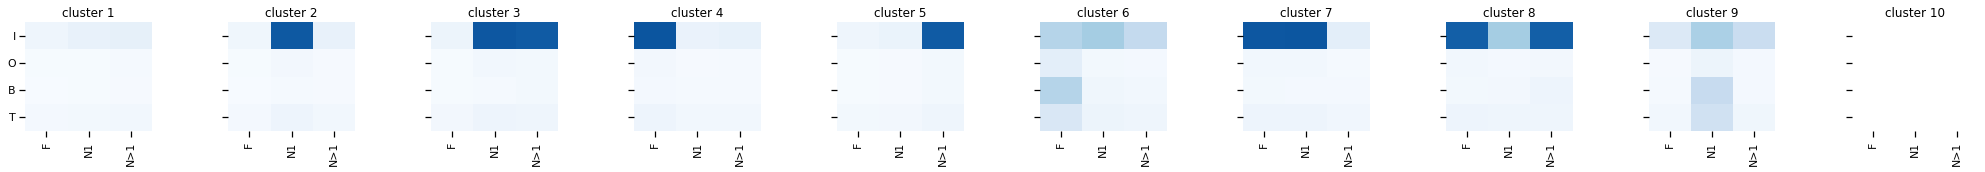

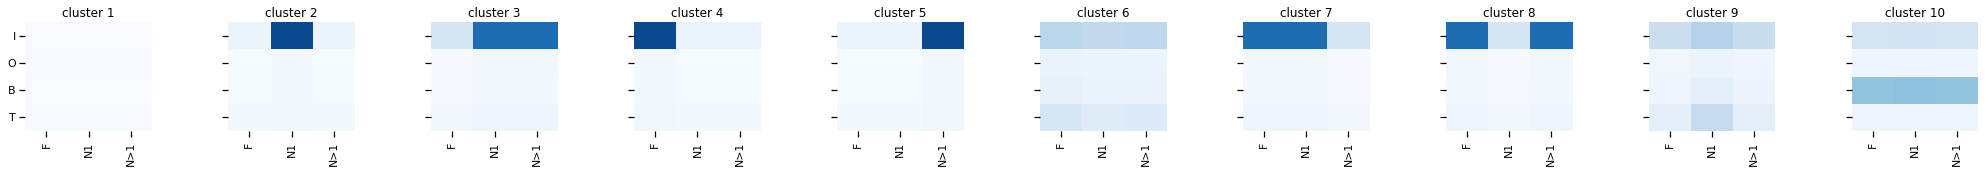

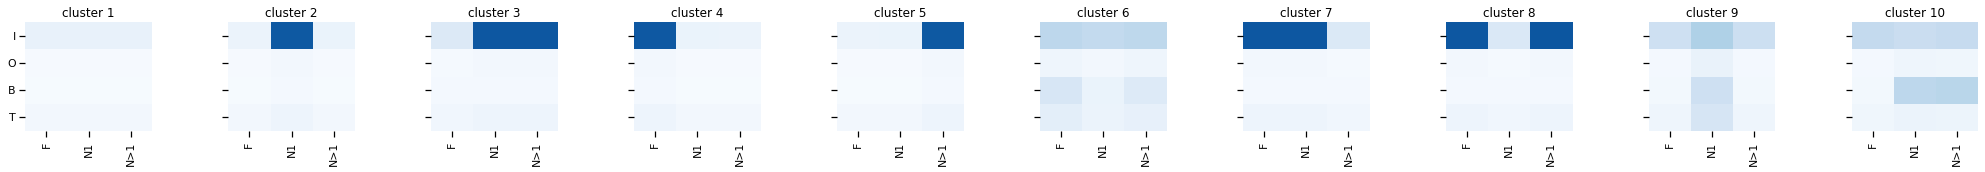

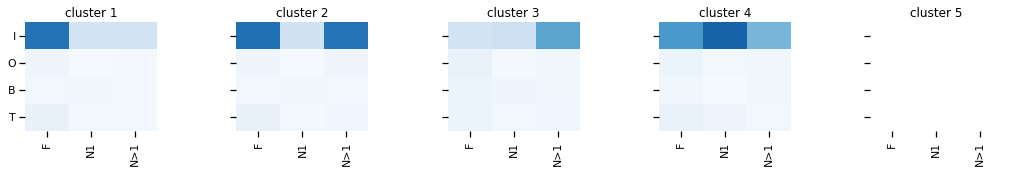

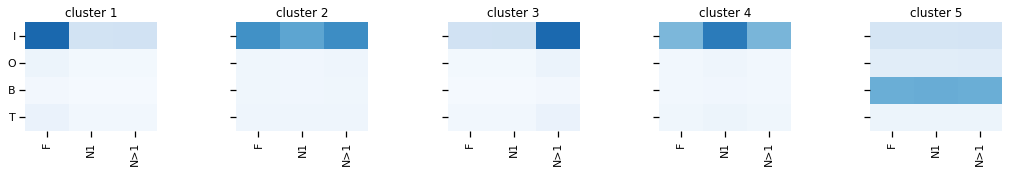

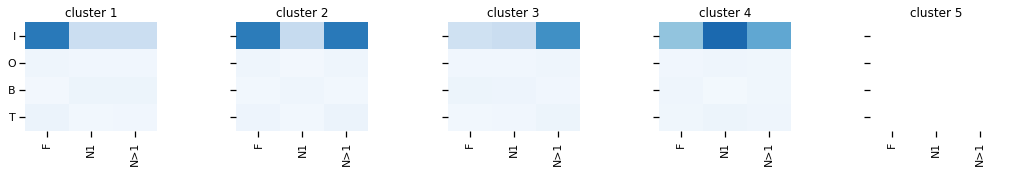

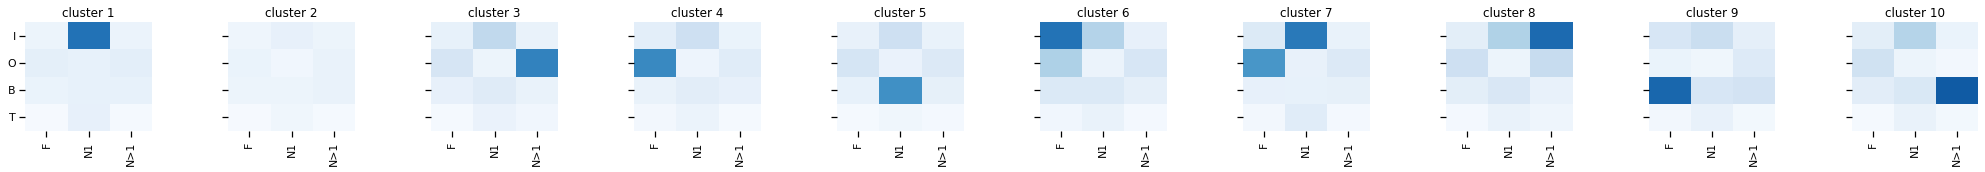

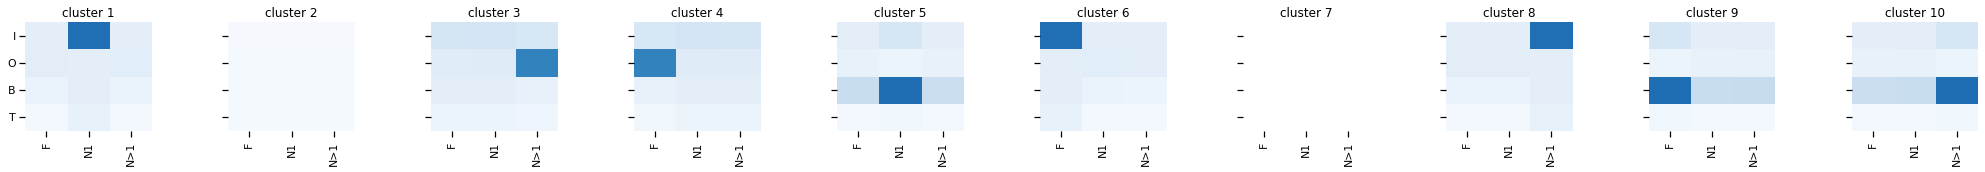

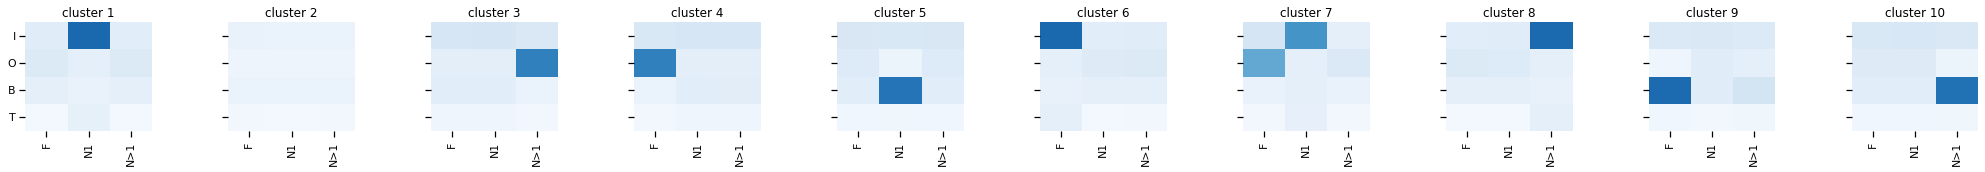

In [233]:

for cre_line in cre_lines:
    for shuffle_type in shuffle_types:
        vba_clust.plot_matched_clusters_heatmap(SSE_mapping = shuffle_type_SSE_mapping, 
                                                mean_dropout_scores_unstacked = shuffle_type_mean_dropout_scores_unstacked ,
                                                cre_line = cre_line, metric='mean',
                                                shuffle_type=shuffle_type, save_dir=save_dir, folder=f'{shuffle_type}{threshold}')



### Plot proportions for matched clusters

In [82]:
cre_original_cluster_sizes = {}
for cre_line in cre_lines:
    tmp = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    cre_original_cluster_sizes[cre_line] = tmp.value_counts('cluster_id')

In [234]:
# convert dictionary into df
probability_df= vba_clust.get_cluster_probability_df(shuffle_type_probabilities)
probability_df.head()

,cre_line,cluster_id,shuffle_type,probability
0,Slc17a7-IRES2-Cre,1,experience,1.0
1,Slc17a7-IRES2-Cre,2,experience,1.0
2,Slc17a7-IRES2-Cre,3,experience,1.0
3,Slc17a7-IRES2-Cre,4,experience,1.0
4,Slc17a7-IRES2-Cre,5,experience,1.0


In [235]:
# convert dictionary to df
cluster_size_difference_df = vba_clust.get_cluster_size_differece_df(cre_original_cluster_sizes, shuffle_type_cluster_sizes)

### Debugging shuffled size match

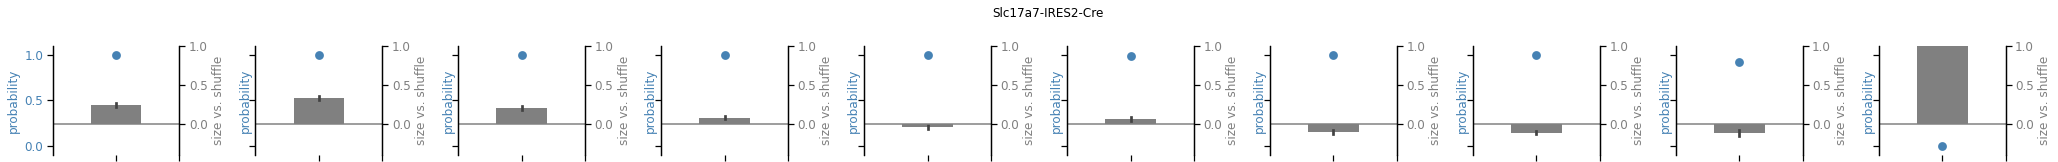

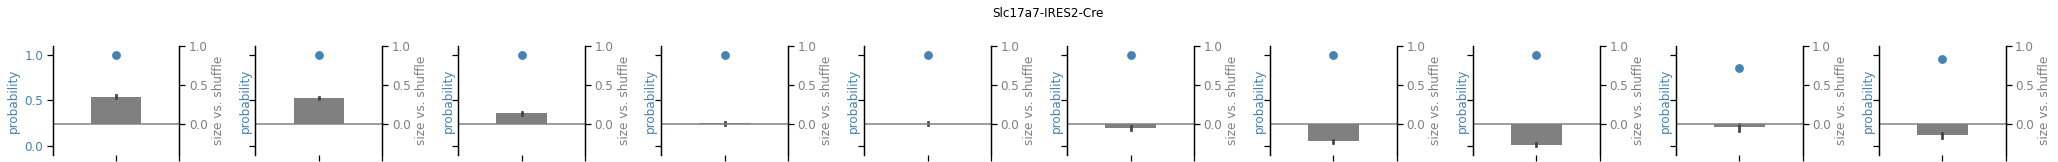

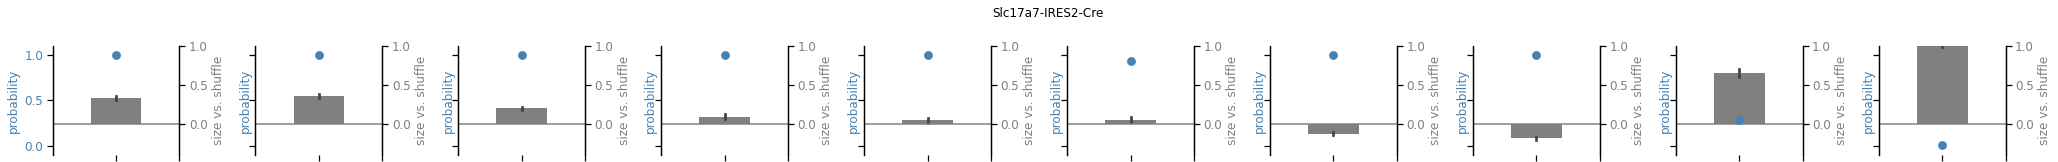

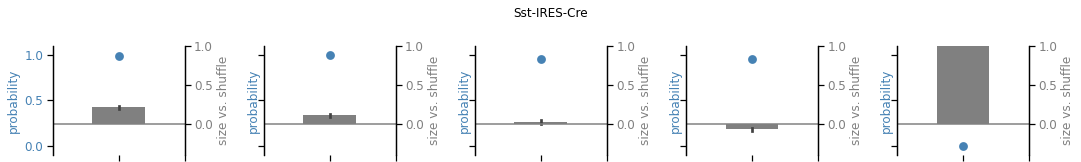

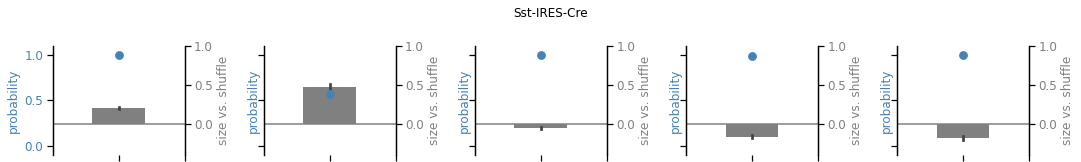

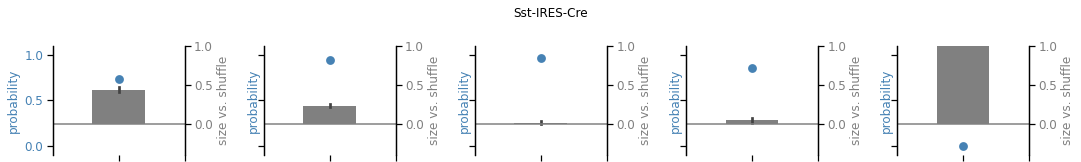

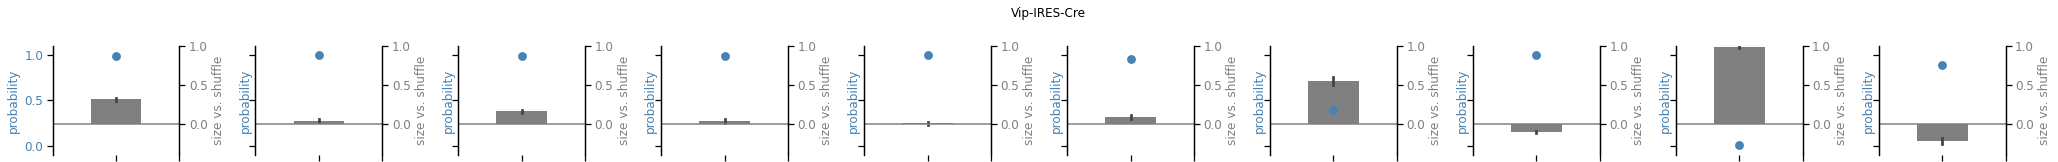

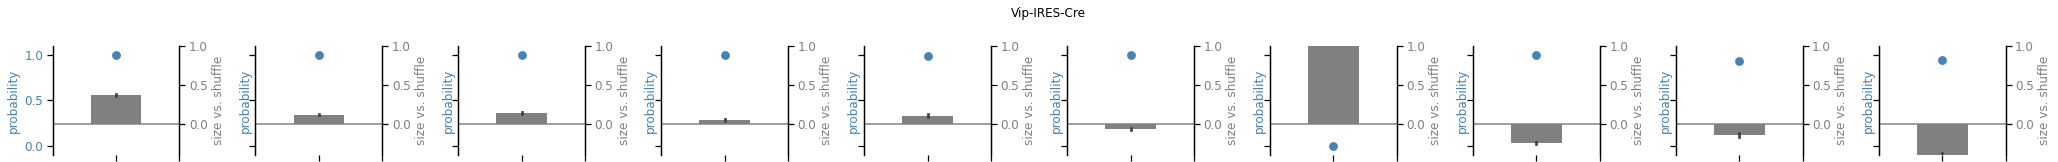

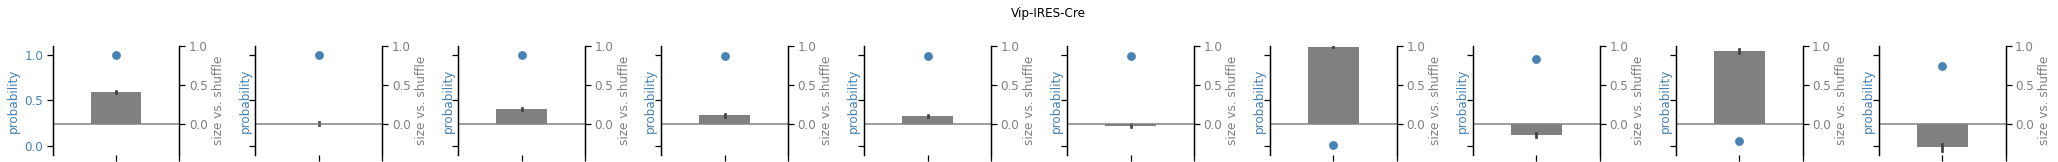

In [236]:
%%capture --no-display 
for cre_line in cre_lines:
    for s, shuffle_type in enumerate(shuffle_types):
        vba_clust.plot_cluster_size_and_probability(cluster_size_difference_df, 
                                                    probability_df, 
                                                    cre_line=cre_line, 
                                                    shuffle_type=shuffle_type,
                                                   save_dir=save_dir,
                                                   folder = f'{shuffle_type}{threshold}')

In [127]:
mean_of_difference_df = cluster_size_difference_df.groupby(['shuffle_type', 'cre_line', 'cluster_id'])['abs_cluster_size_diff'].mean().unstack()
mean_of_difference_df

cluster_id                                     1        2        3       4   \
shuffle_type           cre_line                                               
experience             Slc17a7-IRES2-Cre  210.200  229.384   82.296  -1.086   
                       Sst-IRES-Cre        23.492    9.906   -0.758  -5.042   
                       Vip-IRES-Cre        41.140   -0.296   11.494  -1.400   
experience_within_cell Slc17a7-IRES2-Cre  355.490  284.536   67.890 -30.080   
                       Sst-IRES-Cre        20.832   45.078   -1.804   9.086   
                       Vip-IRES-Cre        49.252   12.130   12.336   4.546   
full_experience        Slc17a7-IRES2-Cre  288.490  275.956  100.478 -20.774   
                       Sst-IRES-Cre        45.946   24.844    9.110  14.822   
                       Vip-IRES-Cre        53.760   -7.962   16.412  10.022   

cluster_id                                    5        6        7        8   \
shuffle_type           cre_line                                               
experience             Slc17a7-IRES2-Cre -95.576   93.212  -96.752  -69.496   
                       Sst-IRES-Cre        6.000      NaN      NaN      NaN   
                       Vip-IRES-Cre       -3.066    5.314   15.510   -8.228   
experience_within_cell Slc17a7-IRES2-Cre -35.562  -85.770 -150.482 -181.212   
                       Sst-IRES-Cre       -6.890      NaN      NaN      NaN   
                       Vip-IRES-Cre        7.114   -3.232   27.000   11.618   
full_experience        Slc17a7-IRES2-Cre -49.700  111.920 -102.460 -123.840   
                       Sst-IRES-Cre        6.000      NaN      NaN      NaN   
                       Vip-IRES-Cre        8.370   11.916   27.000   13.532   

cluster_id                                     9        10  
shuffle_type           cre_line                             
experience             Slc17a7-IRES2-Cre  -44.834  107.000  
                       Sst-IRES-Cre           NaN      NaN  
                       Vip-IRES-Cre        20.000   -3.512  
experience_within_cell Slc17a7-IRES2-Cre    8.186  -88.592  
                       Sst-IRES-Cre           NaN      NaN  
                       Vip-IRES-Cre         0.658  -10.746  
full_experience        Slc17a7-IRES2-Cre  160.466  107.000  
                       Sst-IRES-Cre           NaN      NaN  
                       Vip-IRES-Cre        20.000    2.896

In [128]:
shuffled = cluster_size_difference_df.groupby(['shuffle_type', 'cre_line', 'cluster_id'])['shuffle_size'].mean()
og = cluster_size_difference_df.groupby(['shuffle_type', 'cre_line', 'cluster_id'])['og_cluster_size'].mean()
(og - shuffled).unstack()

cluster_id                                     1        2        3       4   \
shuffle_type           cre_line                                               
experience             Slc17a7-IRES2-Cre  210.200  229.384   82.296  -1.086   
                       Sst-IRES-Cre        23.492    9.906   -0.758  -5.042   
                       Vip-IRES-Cre        41.140   -0.296   11.494  -1.400   
experience_within_cell Slc17a7-IRES2-Cre  355.490  284.536   67.890 -30.080   
                       Sst-IRES-Cre        20.832   45.078   -1.804   9.086   
                       Vip-IRES-Cre        49.252   12.130   12.336   4.546   
full_experience        Slc17a7-IRES2-Cre  288.490  275.956  100.478 -20.774   
                       Sst-IRES-Cre        45.946   24.844    9.110  14.822   
                       Vip-IRES-Cre        53.760   -7.962   16.412  10.022   

cluster_id                                    5        6        7        8   \
shuffle_type           cre_line                                               
experience             Slc17a7-IRES2-Cre -95.576   93.212  -96.752  -69.496   
                       Sst-IRES-Cre        6.000      NaN      NaN      NaN   
                       Vip-IRES-Cre       -3.066    5.314   15.510   -8.228   
experience_within_cell Slc17a7-IRES2-Cre -35.562  -85.770 -150.482 -181.212   
                       Sst-IRES-Cre       -6.890      NaN      NaN      NaN   
                       Vip-IRES-Cre        7.114   -3.232   27.000   11.618   
full_experience        Slc17a7-IRES2-Cre -49.700  111.920 -102.460 -123.840   
                       Sst-IRES-Cre        6.000      NaN      NaN      NaN   
                       Vip-IRES-Cre        8.370   11.916   27.000   13.532   

cluster_id                                     9        10  
shuffle_type           cre_line                             
experience             Slc17a7-IRES2-Cre  -44.834  107.000  
                       Sst-IRES-Cre           NaN      NaN  
                       Vip-IRES-Cre        20.000   -3.512  
experience_within_cell Slc17a7-IRES2-Cre    8.186  -88.592  
                       Sst-IRES-Cre           NaN      NaN  
                       Vip-IRES-Cre         0.658  -10.746  
full_experience        Slc17a7-IRES2-Cre  160.466  107.000  
                       Sst-IRES-Cre           NaN      NaN  
                       Vip-IRES-Cre        20.000    2.896

In [129]:
mean_of_difference_df = cluster_size_difference_df.groupby(['shuffle_type', 'cre_line', 'cluster_id'])['cluster_size_diff'].mean().unstack()
mean_of_difference_df

cluster_id                                      1         2         3   \
shuffle_type           cre_line                                          
experience             Slc17a7-IRES2-Cre  0.237087  0.332395  0.206456   
                       Sst-IRES-Cre       0.258928  0.130347  0.068364   
                       Vip-IRES-Cre       0.318424  0.044912  0.172566   
experience_within_cell Slc17a7-IRES2-Cre  0.350422  0.331413  0.136297   
                       Sst-IRES-Cre       0.204217  0.783970  0.063741   
                       Vip-IRES-Cre       0.370520  0.118522  0.143584   
full_experience        Slc17a7-IRES2-Cre  0.325622  0.360678  0.196549   
                       Sst-IRES-Cre       0.626413  0.343544  0.272194   
                       Vip-IRES-Cre       0.425026 -0.000473  0.196902   

cluster_id                                      4         5         6   \
shuffle_type           cre_line                                          
experience             Slc17a7-IRES2-Cre  0.078963 -0.047437  0.423168   
                       Sst-IRES-Cre       0.053444  1.000000       NaN   
                       Vip-IRES-Cre       0.045619  0.017381  0.177395   
experience_within_cell Slc17a7-IRES2-Cre  0.003881 -0.000068 -0.050463   
                       Sst-IRES-Cre       0.445397 -0.152621       NaN   
                       Vip-IRES-Cre       0.092738  0.166402  0.027033   
full_experience        Slc17a7-IRES2-Cre  0.086474  0.043452  0.563391   
                       Sst-IRES-Cre       0.537001  1.000000       NaN   
                       Vip-IRES-Cre       0.189986  0.197772  0.398639   

cluster_id                                      7         8         9   \
shuffle_type           cre_line                                          
experience             Slc17a7-IRES2-Cre -0.109010 -0.007850  0.158932   
                       Sst-IRES-Cre            NaN       NaN       NaN   
                       Vip-IRES-Cre       0.657181 -0.090607  1.000000   
experience_within_cell Slc17a7-IRES2-Cre -0.227852 -0.271847  0.371212   
                       Sst-IRES-Cre            NaN       NaN       NaN   
                       Vip-IRES-Cre       1.000000  0.621935  0.305616   
full_experience        Slc17a7-IRES2-Cre -0.128153 -0.163355  0.953274   
                       Sst-IRES-Cre            NaN       NaN       NaN   
                       Vip-IRES-Cre       1.000000  0.668356  1.000000   

cluster_id                                      10  
shuffle_type           cre_line                     
experience             Slc17a7-IRES2-Cre  1.000000  
                       Sst-IRES-Cre            NaN  
                       Vip-IRES-Cre       0.223525  
experience_within_cell Slc17a7-IRES2-Cre -0.107414  
                       Sst-IRES-Cre            NaN  
                       Vip-IRES-Cre       0.060821  
full_experience        Slc17a7-IRES2-Cre  1.000000  
                       Sst-IRES-Cre            NaN  
                       Vip-IRES-Cre       0.652300

In [131]:
shuffled = cluster_size_difference_df.groupby(['shuffle_type', 'cre_line', 'cluster_id'])['shuffle_size'].mean()
og = cluster_size_difference_df.groupby(['shuffle_type', 'cre_line', 'cluster_id'])['og_cluster_size'].mean()
((og - shuffled)/(og + shuffled)).unstack()

cluster_id                                      1         2         3   \
shuffle_type           cre_line                                          
experience             Slc17a7-IRES2-Cre  0.168187  0.228785  0.115632   
                       Sst-IRES-Cre       0.216500  0.095164 -0.009624   
                       Vip-IRES-Cre       0.283998 -0.002307  0.116683   
experience_within_cell Slc17a7-IRES2-Cre  0.321853  0.300313  0.093498   
                       Sst-IRES-Cre       0.187392  0.654044 -0.022605   
                       Vip-IRES-Cre       0.360166  0.104686  0.126311   
full_experience        Slc17a7-IRES2-Cre  0.246255  0.288644  0.144881   
                       Sst-IRES-Cre       0.533921  0.278658  0.132240   
                       Vip-IRES-Cre       0.406534 -0.058560  0.175364   

cluster_id                                      4         5         6   \
shuffle_type           cre_line                                          
experience             Slc17a7-IRES2-Cre -0.001705 -0.130644  0.211467   
                       Sst-IRES-Cre      -0.073028  1.000000       NaN   
                       Vip-IRES-Cre      -0.015317 -0.037821  0.079687   
experience_within_cell Slc17a7-IRES2-Cre -0.045160 -0.052954 -0.138390   
                       Sst-IRES-Cre       0.165459 -0.364743       NaN   
                       Vip-IRES-Cre       0.053198  0.100358 -0.042960   
full_experience        Slc17a7-IRES2-Cre -0.031630 -0.072481  0.265163   
                       Sst-IRES-Cre       0.301395  1.000000       NaN   
                       Vip-IRES-Cre       0.125309  0.120207  0.198322   

cluster_id                                      7         8         9   \
shuffle_type           cre_line                                          
experience             Slc17a7-IRES2-Cre -0.197150 -0.161808 -0.112979   
                       Sst-IRES-Cre            NaN       NaN       NaN   
                       Vip-IRES-Cre       0.402962 -0.141307  1.000000   
experience_within_cell Slc17a7-IRES2-Cre -0.276376 -0.334826  0.023809   
                       Sst-IRES-Cre            NaN       NaN       NaN   
                       Vip-IRES-Cre       1.000000  0.302694  0.016725   
full_experience        Slc17a7-IRES2-Cre -0.206381 -0.255952  0.837794   
                       Sst-IRES-Cre            NaN       NaN       NaN   
                       Vip-IRES-Cre       1.000000  0.371065  1.000000   

cluster_id                                      10  
shuffle_type           cre_line                     
experience             Slc17a7-IRES2-Cre  1.000000  
                       Sst-IRES-Cre            NaN  
                       Vip-IRES-Cre      -0.137661  
experience_within_cell Slc17a7-IRES2-Cre -0.292777  
                       Sst-IRES-Cre            NaN  
                       Vip-IRES-Cre      -0.328162  
full_experience        Slc17a7-IRES2-Cre  1.000000  
                       Sst-IRES-Cre            NaN  
                       Vip-IRES-Cre       0.151591

#### plot correlation bar plot

In [134]:
shuffle_corr_dict = {}
for shuffle_type in shuffle_types:
    corr_dict = {}
    for cre_line in cre_lines:
        corr_dict[cre_line]= vba_clust.get_corr_for_matched_clusters_dict(shuffle_type_SSE_mapping, 
                                                       shuffle_type_mean_dropout_scores,
                                                        shuffle_type = shuffle_type,
                                                       cre_line = cre_line)
    shuffle_corr_dict[shuffle_type] = corr_dict


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


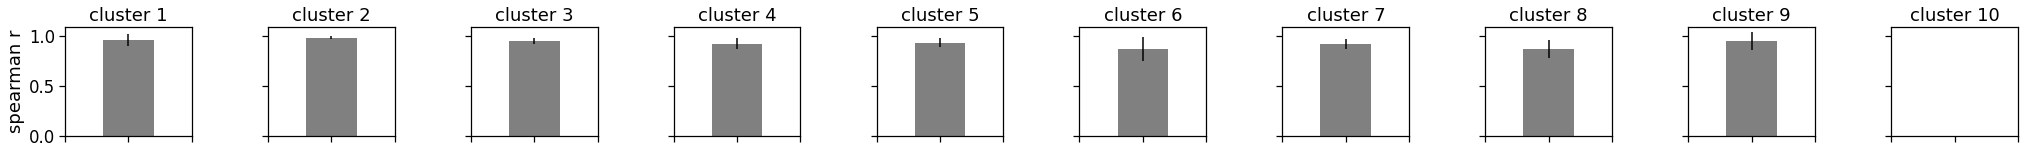

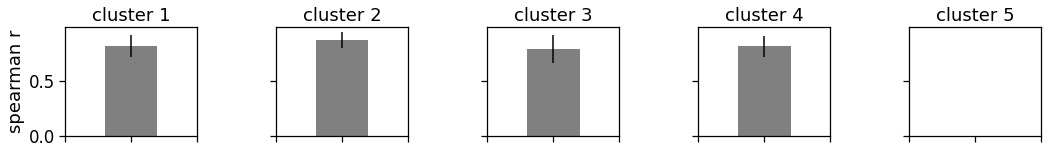

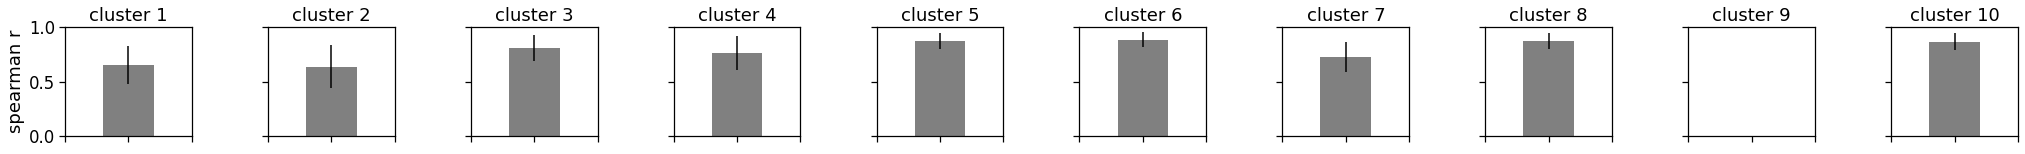

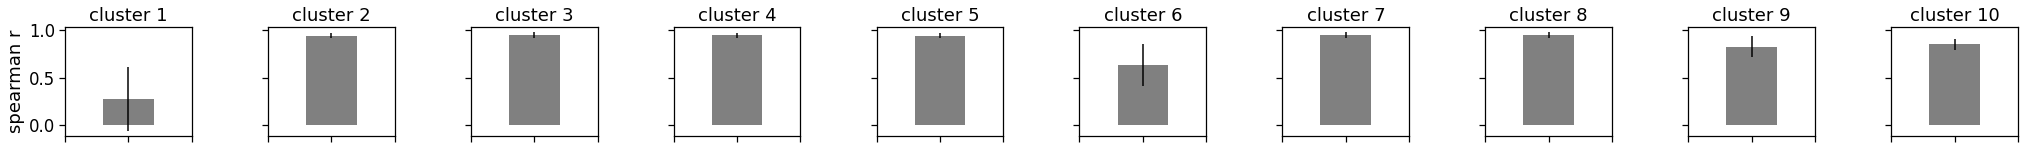

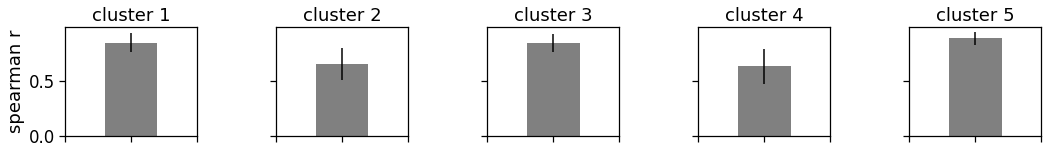

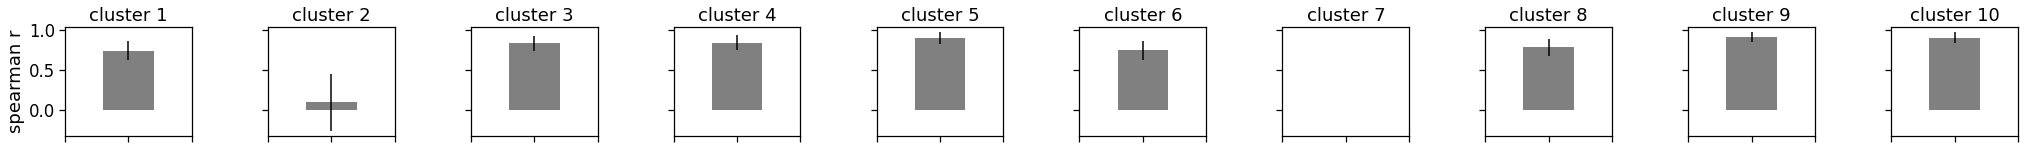

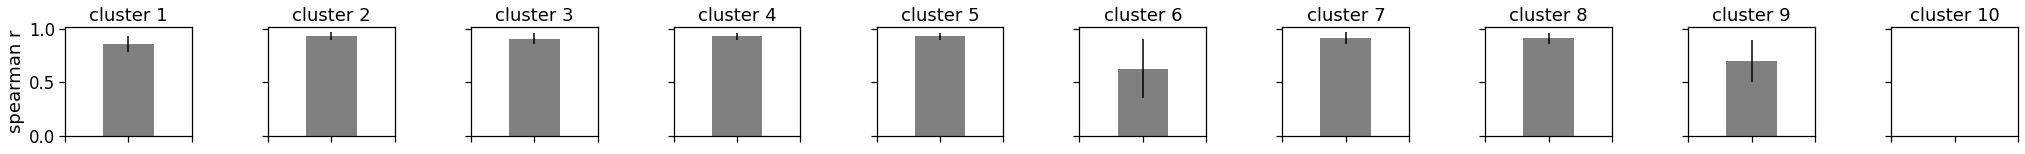

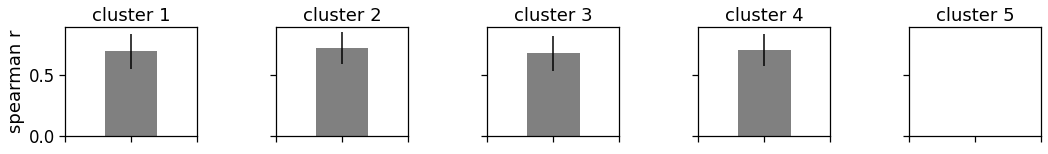

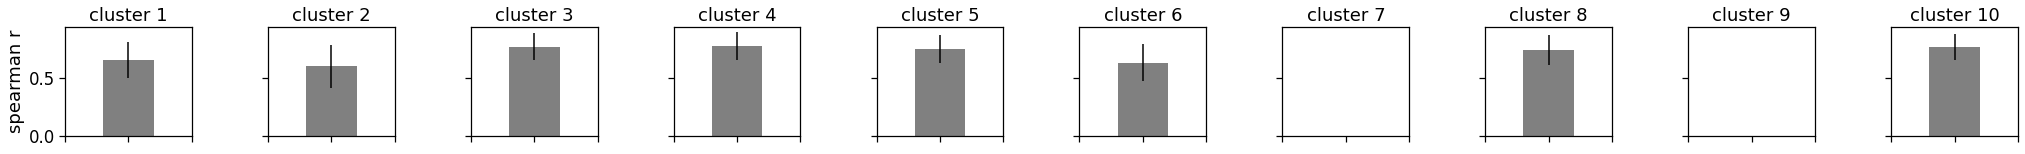

In [135]:

for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        corr_dict = shuffle_corr_dict[shuffle_type][cre_line]
        n_clusters = len(corr_dict.keys())
        figsize=(3.5*n_clusters,2)
        fig, ax = plt.subplots(1,n_clusters, figsize = figsize, sharey='row')
        for i, cluster_id in  enumerate(corr_dict.keys()):
            ax[i].bar(cluster_id, corr_dict[cluster_id][0], color='Grey')
            ax[i].errorbar(cluster_id, corr_dict[cluster_id][0], corr_dict[cluster_id][1], 
                        color='k')
            ax[i].set_xticklabels([cluster_id])
            if i ==0 :
                ax[i].set_ylabel('spearman r')
            ax[i].set_xlabel('')
            ax[i].set_title(f'cluster {cluster_id}')
            ax[i].set_xticklabels('')
            ax[i].set_xlim([cluster_id-1, cluster_id+1])

        #plt.suptitle(cre_line + ' ' + shuffle_type)
        fig.subplots_adjust(hspace=1.2, wspace=0.6)
        utils.save_figure(fig, figsize, save_dir, f'{shuffle_type}{threshold}',
                      f'{shuffle_type}_spearman_within_matched_' + cre_line[:3]  )


### match SSE matric with cluster mean dropout plots

In [136]:
def make_dict(matrix):
    rows = np.shape(matrix)[0]
    new_dict = {}
    for row in range(rows):
        new_dict[row+1] = matrix[row]
    
    return new_dict

In [237]:
%%time
# compute mean SSE matrix of matched clusters
shuffle_type_SSE_all = {}
for shuffle_type in shuffle_types:
    cre_SSE_all = {}
    for cre_line in cre_lines:
        
        n_boots = shuffle_type_SSE[shuffle_type][cre_line].keys()
        cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][0]
        
        # create a data frame to collect sorted SSE from all n_boots
        SSE_values_sorted_df = pd.DataFrame(columns=['cluster_id', *cluster_ids])
        
        # run over all nboots and sort SSE using orignal cluster sort
        for n in n_boots:
            
            # Get matched map and SSE matrix for this n boot
            SSE_values = shuffle_type_SSE[shuffle_type][cre_line][n]
            SSE_map = shuffle_type_SSE_mapping[shuffle_type][cre_line][n]
            #print(SSE_map)
            # convert SSE matrix to df for easier operation
            nb_values_df = pd.DataFrame(make_dict(SSE_values))
            #print(nb_values_df)
            # make a copy which will be used to store sorted SSE values
            nb_sorted_df = nb_values_df.copy()
            # first sort SSE values
            for cluster_id in SSE_map.keys():
                matched_cluster_id = SSE_map[cluster_id] # matched shuddled cluster id
                
                # copy matched SSE value to a new location in df
                if matched_cluster_id!=-1:
                    nb_sorted_df.loc[cluster_id-1][:] = nb_values_df.loc[matched_cluster_id-1][:].values
                else:
                    #nb_sorted_df.loc[cluster_id-1][cluster_id]=np.nan
                    nb_sorted_df.loc[cluster_id-1][:]=np.nan
            
            
            # reset index and rename cluster id column
            nb_sorted_df = nb_sorted_df.reset_index(drop=True)
            nb_sorted_df['cluster_id'] = np.arange(1, len(cluster_ids)+1)
            
            
            # append to larger df with all n_boots
            SSE_values_sorted_df = SSE_values_sorted_df.append(nb_sorted_df, ignore_index=True)
        cre_SSE_all[cre_line] = SSE_values_sorted_df
    shuffle_type_SSE_all[shuffle_type] = cre_SSE_all
                
    
    

Wall time: 18 s


#### plot heatmap of mean SSE values by with cluster id heatmaps

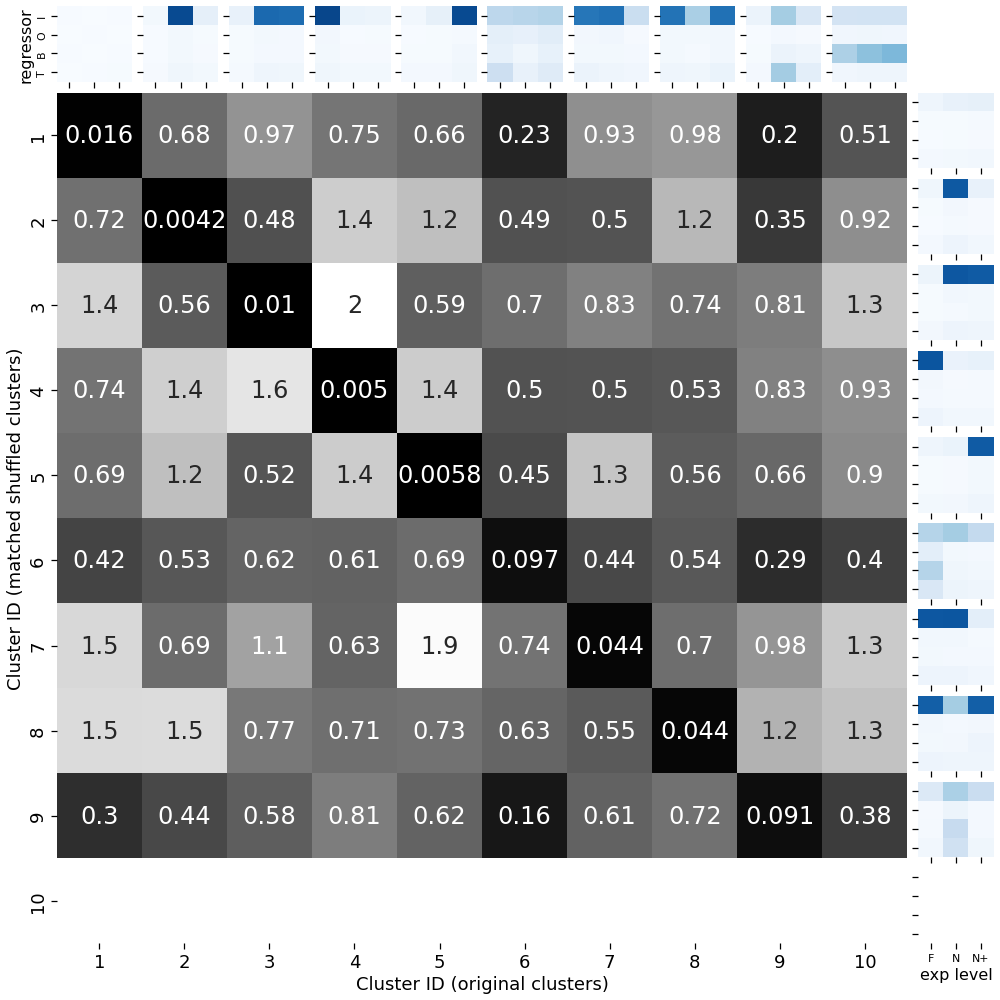

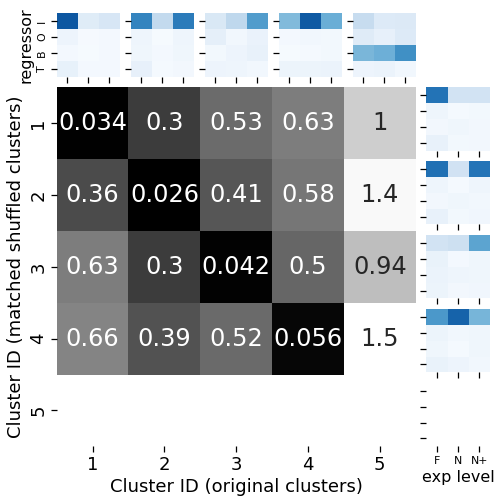

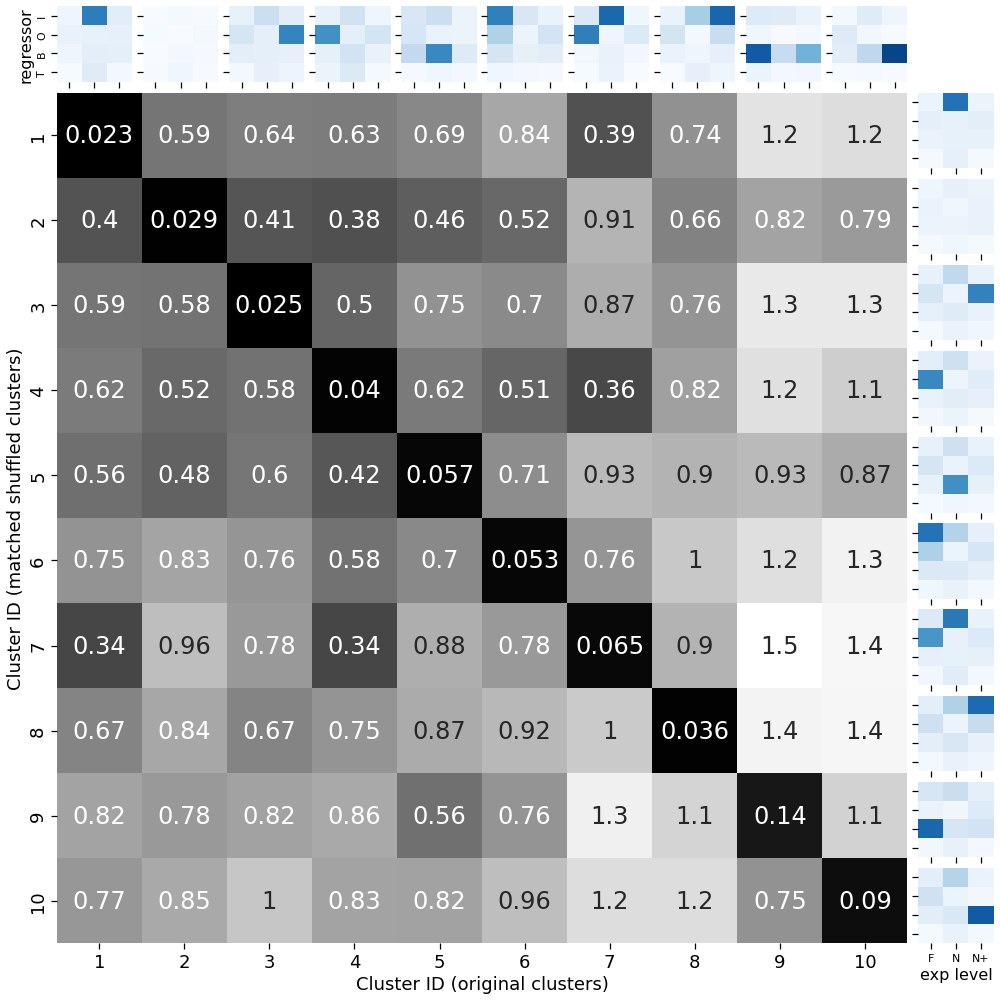

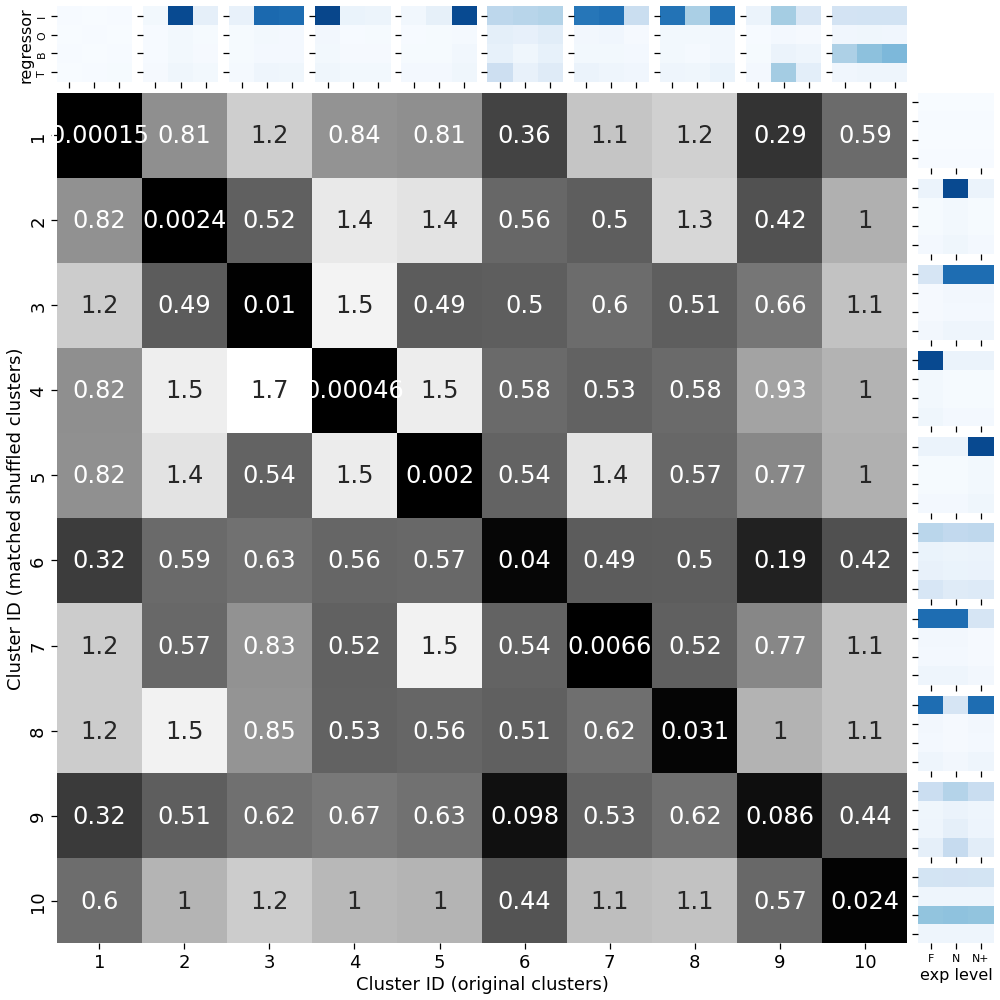

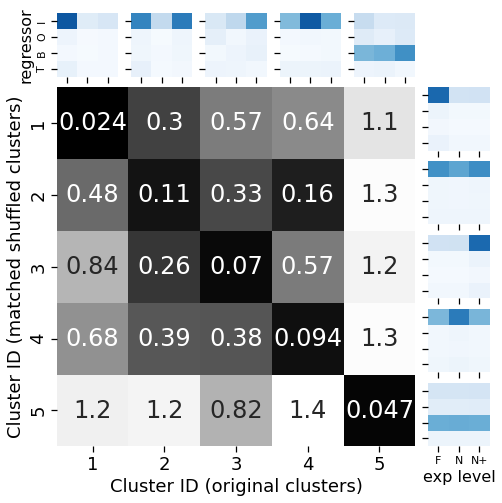

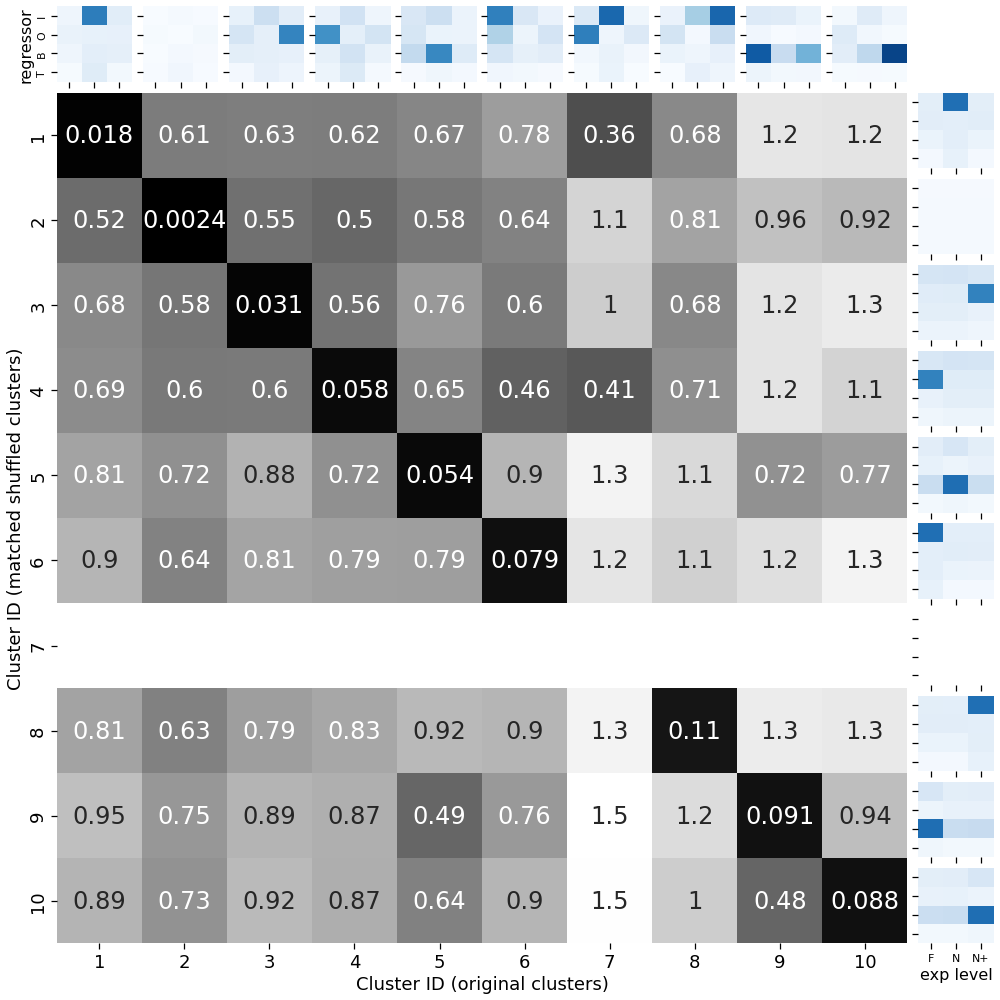

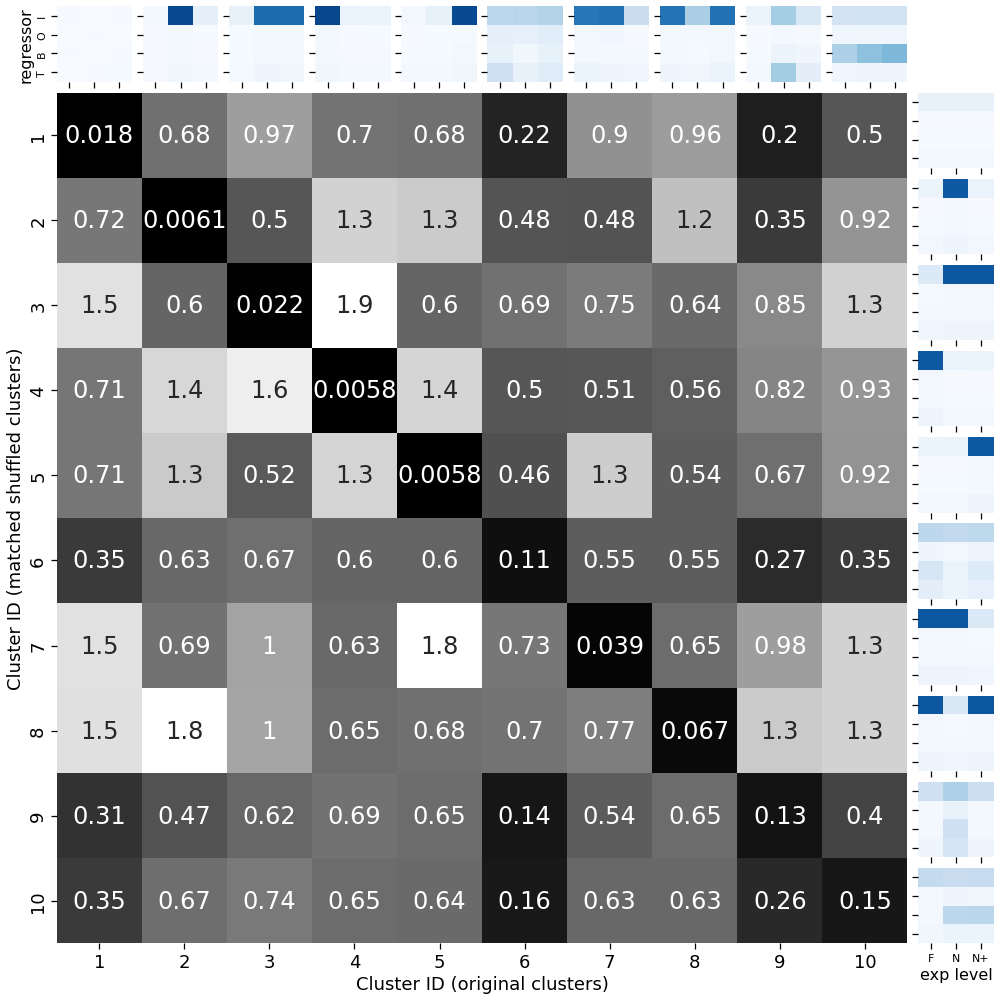

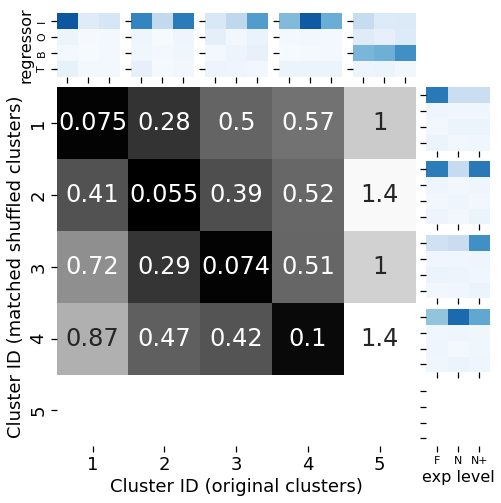

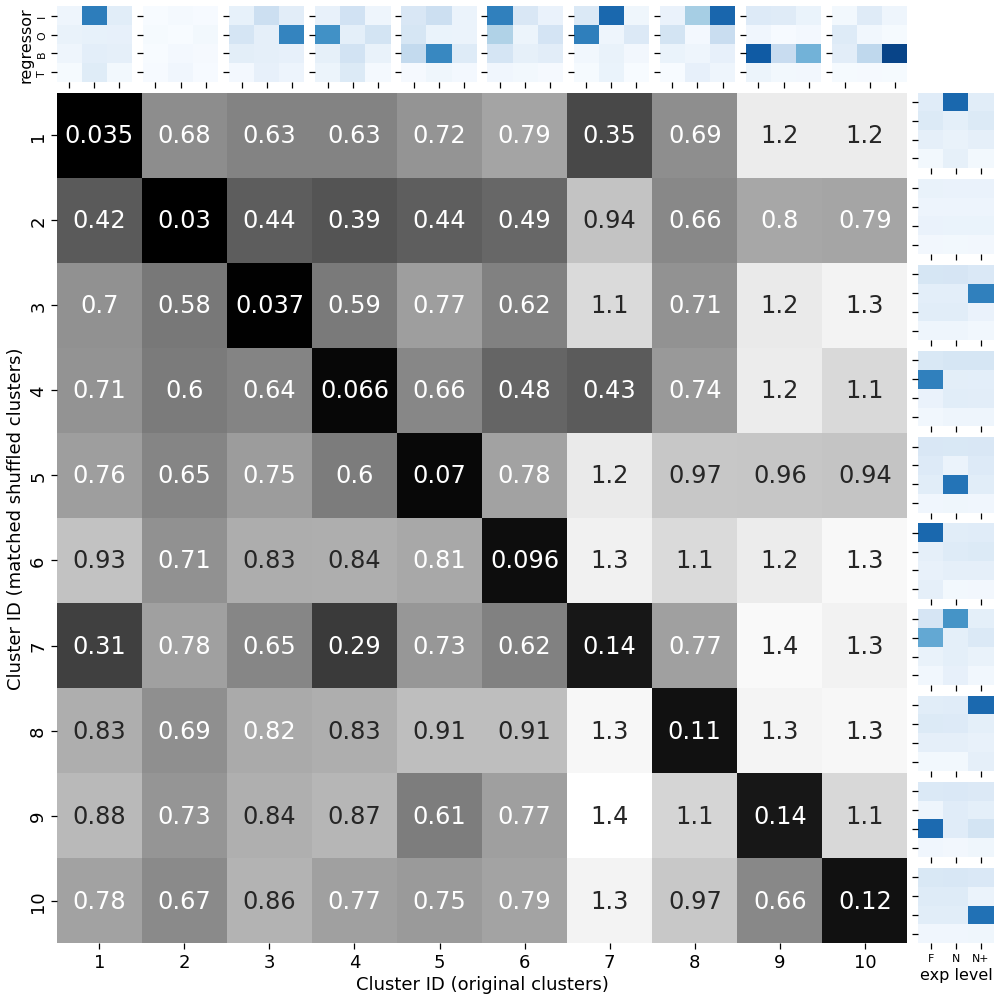

In [238]:
### make one mean figure with diagonal SSE matching plot

import matplotlib.gridspec as gr
figsizes =  [(14,14), (7, 7), (14,14)]
for shuffle_type in shuffle_types:
    for c,cre_line in enumerate(cre_lines):
        SSE_mapping = shuffle_type_SSE_mapping
        
        shuffled = vba_clust.get_matched_clusters_means_dict(SSE_mapping, shuffle_type_mean_dropout_scores_unstacked, metric='mean', shuffle_type=shuffle_type,
                                    cre_line=cre_line)      
        original = cre_original_clusters_unstacked[cre_line]
        cluster_ids = shuffled.keys()
        n_clusters = len(cluster_ids)
            
            
        gs = gr.GridSpec(n_clusters+1, n_clusters+1, width_ratios=[2]*(n_clusters+1), height_ratios=[2]*(n_clusters+1))
        fig = plt.figure(figsize = figsizes[c])
            
        # plot original
        for i, cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(gs[0, i])
            ax = sns.heatmap(original[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
            if i!=0:
                ax.set_yticklabels('')
            else:
                ax.set_ylabel('regressor', fontsize=16)
            ax.set_xticklabels('')
            ax.set_xlabel('')

        # plot shuffled clusters
        for i, cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(gs[cluster_id, n_clusters])
            if shuffled[cluster_id].sum().sum() != 0:
                ax = sns.heatmap(shuffled[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
            else:
                ax = sns.heatmap(shuffled[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Greys",vmin=0, vmax=1,cbar=False, ax=ax)
                
            ax.set_yticklabels('')
            ax.set_xlabel('')
            ax.set_ylabel('')
            if cluster_id !=n_clusters:
                ax.set_xticklabels('')
            else:
                ax.set_xlabel('exp level', fontsize=16)


         # Plot SSE
        tmp = shuffle_type_SSE_all[shuffle_type][cre_line].groupby('cluster_id').mean()        
        labels=np.arange(1,len(tmp)+1)
        ax = fig.add_subplot(gs[1:,:n_clusters])
        ax=sns.heatmap(tmp, annot=True, cmap = 'Greys_r', annot_kws= {"size": 24},
                            yticklabels=labels, xticklabels=labels,cbar=False,ax=ax)
        
        ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
        ax.set_ylabel('Cluster ID (matched shuffled clusters)', fontsize=18)
        ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
        ax.set_xlabel('Cluster ID (original clusters)', fontsize=18)

        plt.tight_layout()
        utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder='mean_SSE_plots',
                      fig_title=f'mean_SSE_heatmap_{shuffle_type}{threshold}_{cre_line[:3]}_tmp')
        


### Statistics

In [239]:
from scipy.stats import chisquare
#from scipy.stats import power_divergence
#from scipy.stats import fisher_exact

In [193]:
def stats(df,cre_line, shuffle_type):
    '''
        Performs chi-squared tests to asses whether the observed cell counts in each area/depth differ
        significantly from the average for that cluster. 
    '''    

    # compute cell counts in each area/cluster
    table = df.query('cre_line == @cre').groupby(['cluster_id','location'])['cell_specimen_id'].count().unstack()
    table = table[areas]
    table = table.fillna(value=0)

    # compute proportion for null hypothesis that areas have the same proportions
    table['total_cells'] = table.sum(axis=1)
    table['null_mean_proportion'] = table['total_cells']/np.sum(table['total_cells'])

    # second table of cell counts in each area/cluster
    table2 = df.query('cre_line == @cre').groupby(['cluster_id','location'])['cell_specimen_id'].count().unstack()
    table2 = table2[areas]
    table2 = table2.fillna(value=0)

    # compute estimated frequency of cells based on average fraction for each cluster
    for a in areas:
        table2[a+'_chance_count'] = table2[a].sum()*table['null_mean_proportion']

    # perform chi-squared test
    area_chance = [area+'_chance_count' for area in areas]
    for index in table2.index.values:
        f = table2.loc[index][areas].values
        f_expected = table2.loc[index][area_chance].values
        
        # Manually doing check here bc Im on old version of scipy
        assert np.abs(np.sum(f) - np.sum(f_expected))<1, 'f and f_expected must be the same'
        out = chisquare(f,f_expected)
        table2.at[index, 'pvalue'] = out.pvalue
        table2.at[index, 'significant'] = out.pvalue < 0.05

    # Use Benjamini Hochberg Correction for multiple comparisons
    table2 = add_hochberg_correction(table2) 
    return table2

In [194]:

def add_hochberg_correction(table, test='chi_squared_'):
    '''
        Performs the Benjamini Hochberg correction
    '''    
    table = table.sort_values(by=test+'pvalue').reset_index()
    
    # compute the corrected pvalue based on the rank of each test
    # Need to use rank starting at 1
    table['imq'] = (1+table.index.values)/len(table)*0.05
    # print(table)

    # Find the largest pvalue less than its corrected pvalue
    # all tests above that are significant
    table['bh_significant'] = False
    passing_tests = table[table[test+'pvalue'] < table['imq']]
    
    if len(passing_tests) >0:
        last_index = table[table[test+'pvalue'] < table['imq']].tail(1).index.values[0]
        # print(last_index)
        table.at[last_index,'bh_significant'] = True
        table.at[0:last_index,'bh_significant'] = True
    
    # reset order of table and return
    return table.sort_values(by='cluster_id')

In [300]:
cre_original_cluster_sizes[cre_line]

cluster_id
1     93
2     64
3     55
4     45
5     39
6     36
7     27
8     25
9     20
10    11
dtype: int64

In [240]:
# chi_squared test
def get_stats_table(
cluster_statistics_df = pd.DataFrame(columns = ['shuffle_type', 'cre_line', 'cluster_id', 'cluster_size', 'shuffle_mean', 
                                                'chi_squared_pvalue', 'significant'])
index=0
for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        
        table = pd.DataFrame(shuffle_type_cluster_sizes[shuffle_type][cre_line]).mean(axis=0)
        # original cluster sizes
        table2 = cre_original_cluster_sizes[cre_line]
        
        for cluster_id in table2.index:
            f_observed = [table.loc[cluster_id], table2.sum()-table.loc[cluster_id]]
            f_expected = [table2.loc[cluster_id], table2.sum()-table2.loc[cluster_id]]
       
            out =chisquare(f_observed, f_expected)
            cluster_statistics_df.at[index, 'shuffle_type'] = shuffle_type
            cluster_statistics_df.at[index, 'cre_line'] = cre_line
            cluster_statistics_df.at[index, 'cluster_id'] = cluster_id
            cluster_statistics_df.at[index, 'cluster_size'] = table2.loc[cluster_id]
            cluster_statistics_df.at[index, 'shuffle_mean'] = table.loc[cluster_id]
            cluster_statistics_df.at[index, 'chi_squared_pvalue'] = out.pvalue
            cluster_statistics_df.at[index, 'significant'] = out.pvalue <= 0.05
            index=index+1
        

In [241]:
first = True
for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        table = cluster_statistics_df[(cluster_statistics_df.cre_line == cre_line) &
                                      (cluster_statistics_df.shuffle_type == shuffle_type)]
        test = add_hochberg_correction(table)
        if first is True:
            stats_table = add_hochberg_correction(table)
            first = False
        else:
            stats_table = stats_table.append(add_hochberg_correction(table), ignore_index=True)
        
        

#### plots with statistics of cluster sizes

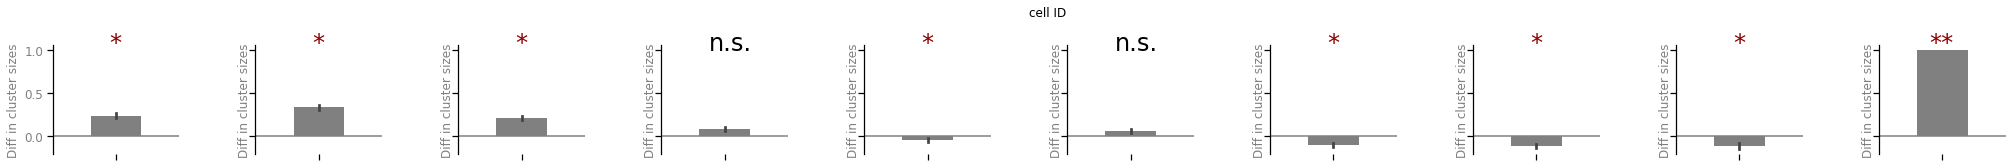

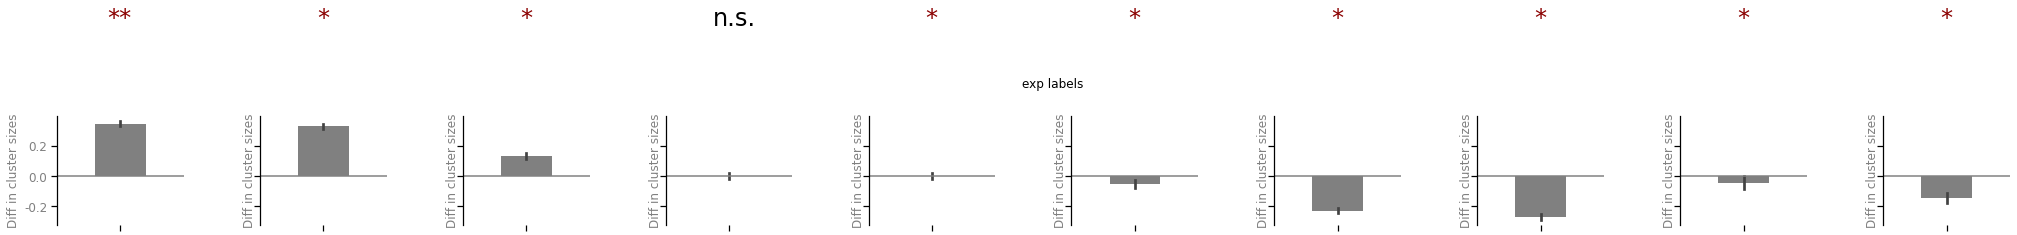

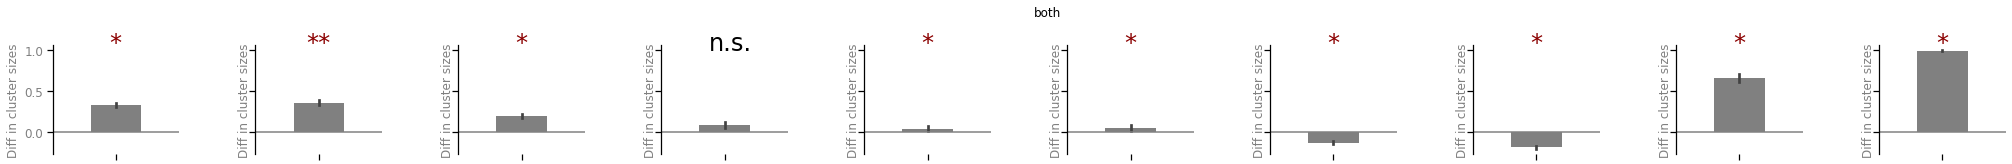

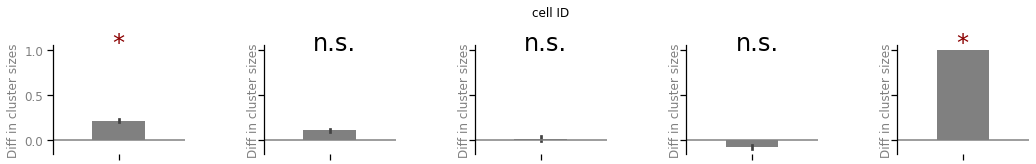

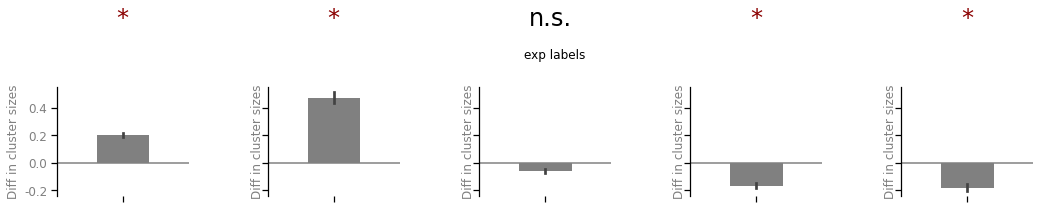

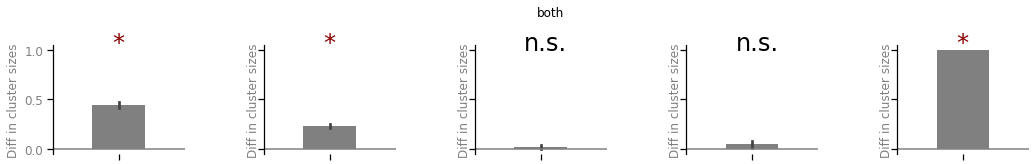

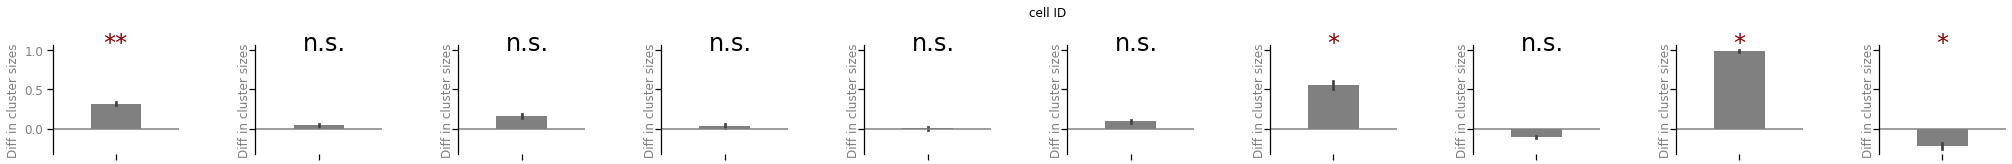

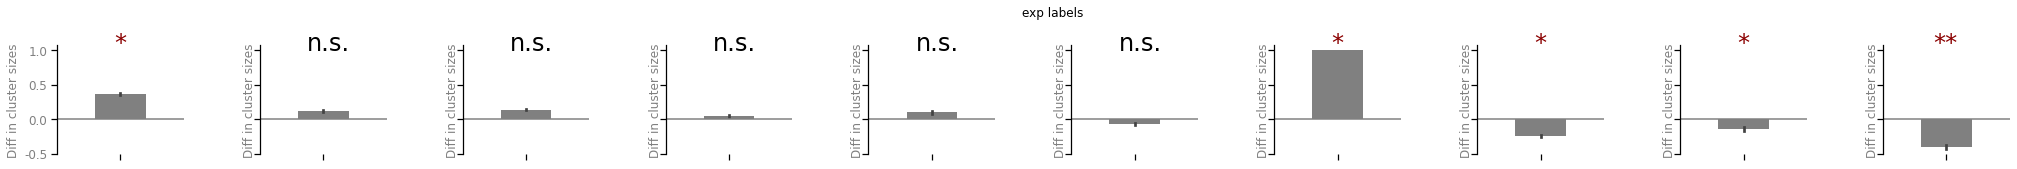

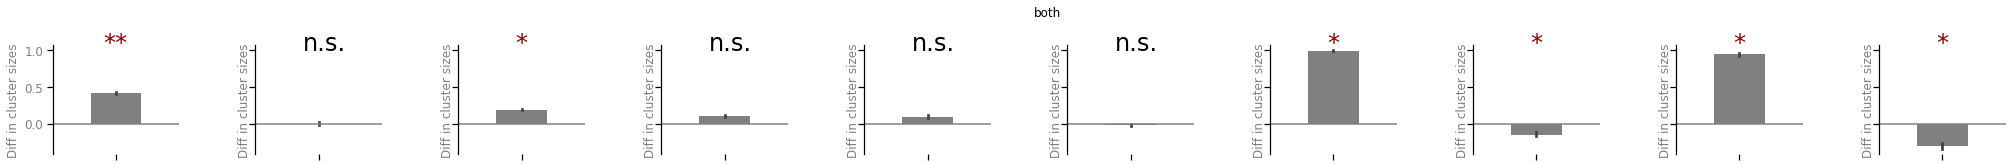

In [242]:
%%capture --no-display 
for cre_line in cre_lines:
    for s, shuffle_type in enumerate(shuffle_types):
        vba_clust.plot_cluster_size(cluster_size_difference_df,  
                                                    cre_line=cre_line, 
                                                    shuffle_type=shuffle_type,
                                                   save_dir=save_dir,
                                                   folder = f'cluster_size_diff_plots_{threshold}', 
                                                    stats_table = stats_table)

#### plot stats_table

In [147]:
difference = (stats_table['cluster_size'] - stats_table['shuffle_mean'])/(stats_table['cluster_size'] + stats_table['shuffle_mean'])

In [148]:
stats_table.loc[difference.index.values, 'cluster_diff'] = difference

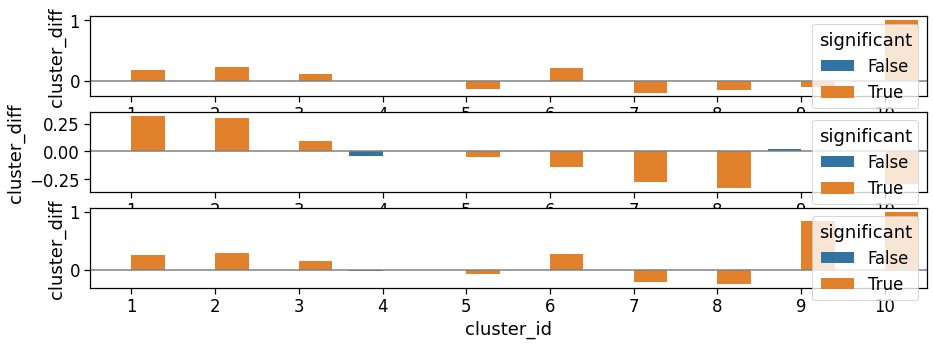

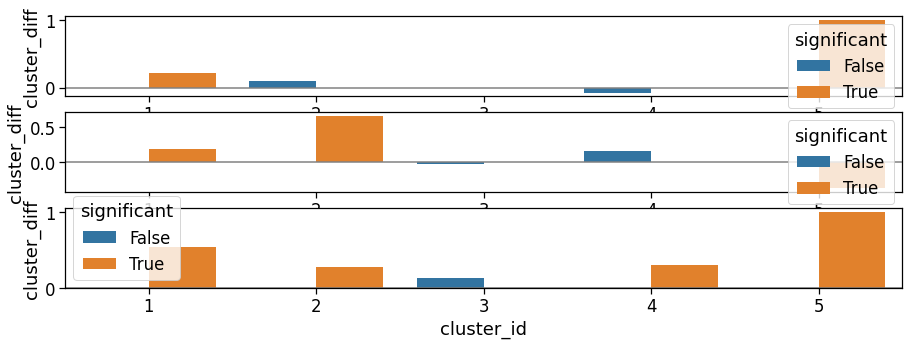

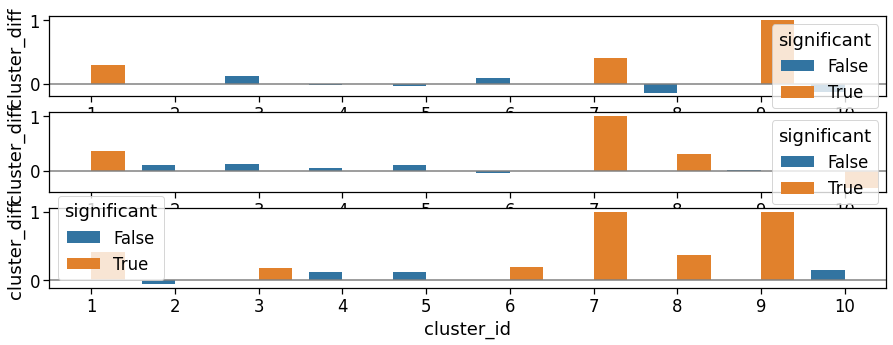

In [150]:
for cre_line in cre_lines:

    fig, ax = plt.subplots(3,1, figsize = (15,5))
    for s, shuffle_type in enumerate(shuffle_types):
        tmp = stats_table[(stats_table['shuffle_type']==shuffle_type) &
                   (stats_table['cre_line']==cre_line)]
        
        ax[s] = sns.barplot(data=tmp, x = 'cluster_id', 
                            y = 'cluster_diff', hue='significant',ax=ax[s] )
        ax[s].axhline(y=0, color='Grey')
        

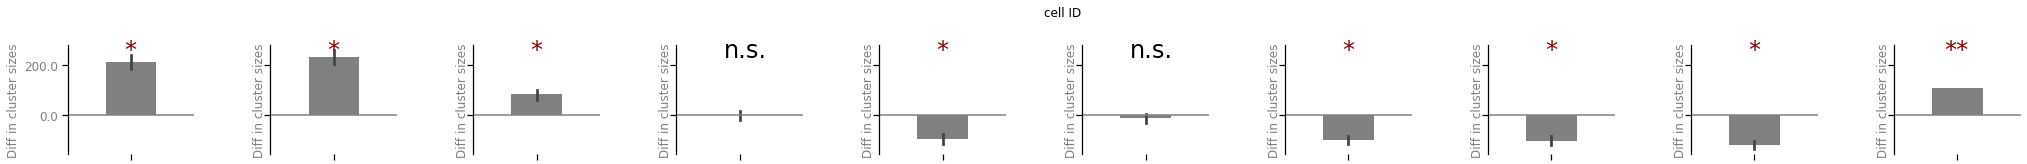

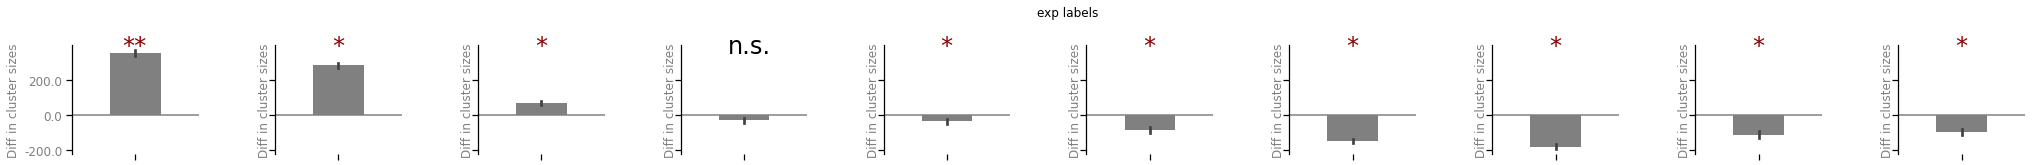

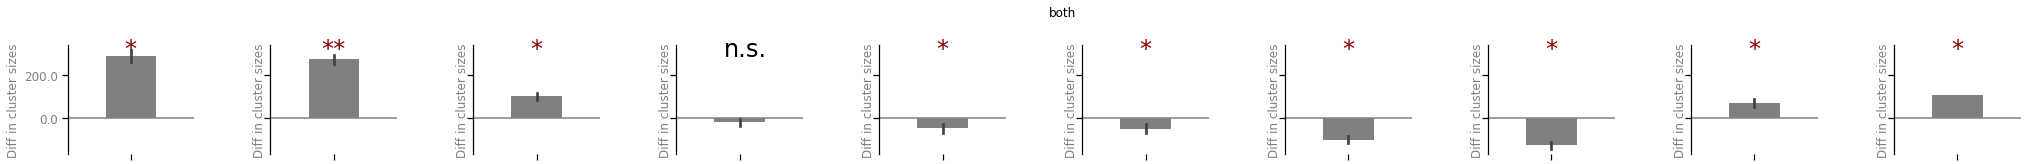

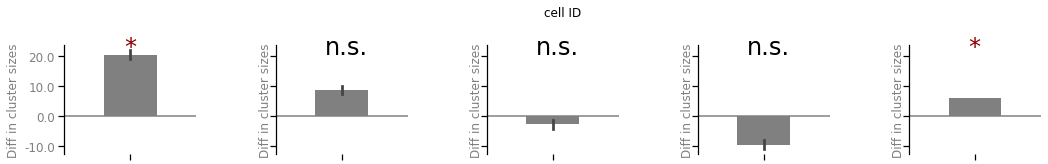

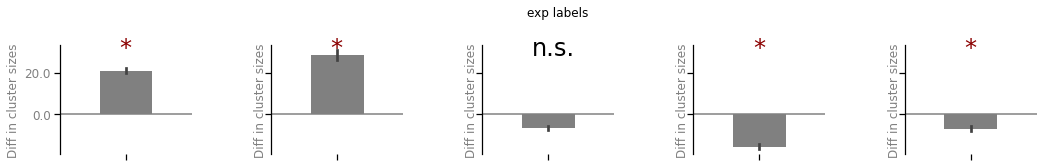

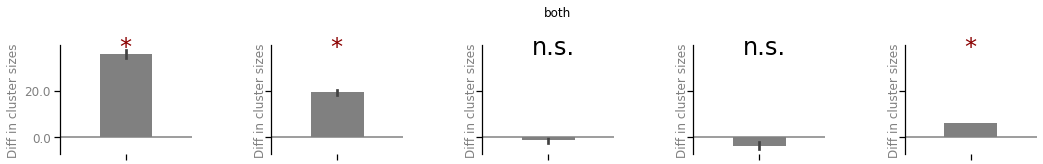

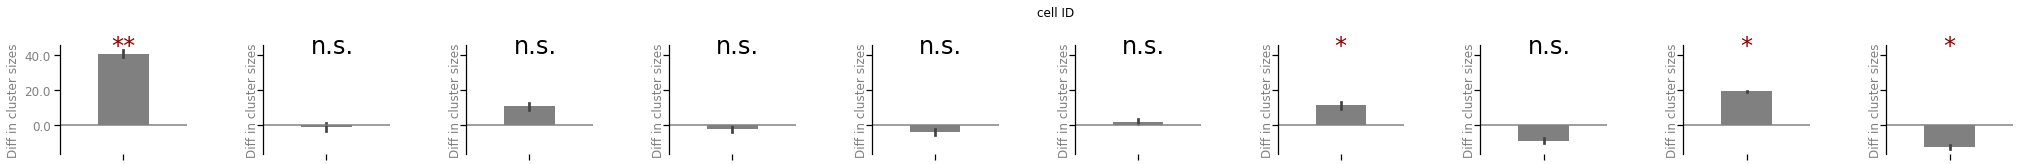

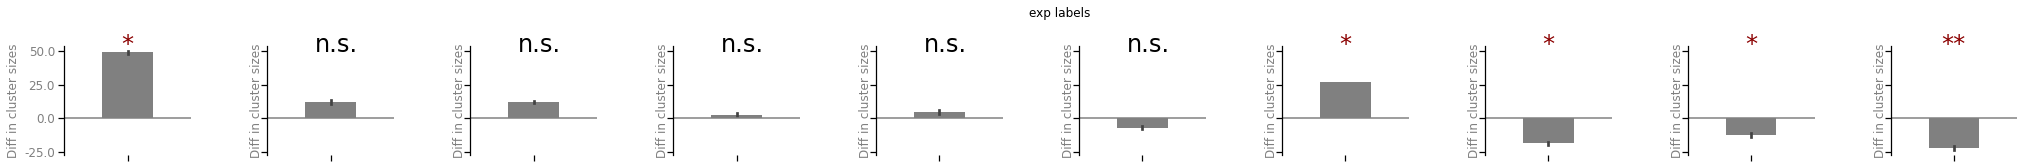

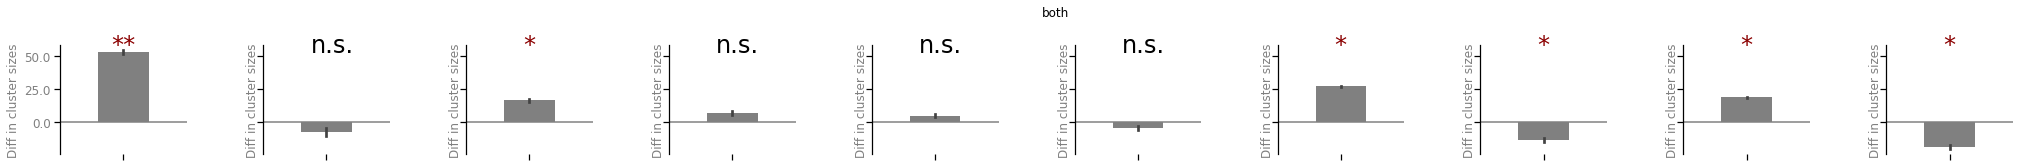

In [243]:
%%capture --no-display 
for cre_line in cre_lines:
    for s, shuffle_type in enumerate(shuffle_types):
        vba_clust.plot_cluster_size(cluster_size_difference_df,  
                                                    cre_line=cre_line, 
                                                    shuffle_type=shuffle_type,
                                                   save_dir=save_dir,
                                                    diff_column = 'abs_cluster_size_diff',
                                                   folder = f'cluster_size_diff_plots_{threshold}', 
                                                    stats_table = stats_table)

#### Plot proportions of clusters by depth or area 

In [280]:
table, stats = vba_clust.get_proportion_cells_rel_cluster_average(df_meta, cre_lines, columns_to_groupby=['layer'])

In [299]:
# import pickle
# file = open(os.path.join(save_dir,'proportions_table.pkl'), 'wb')
# # dump information to the file
# pickle.dump(table, file)
# # close the file
# file.close()

array([<AxesSubplot:title={'center':'Exc cluster 6'}>,
       <AxesSubplot:xlabel='proportion'>,
       <AxesSubplot:title={'left':'8.1%'}>], dtype=object)

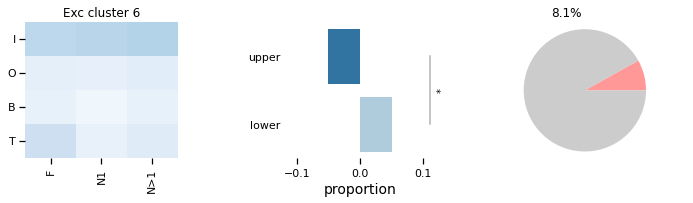

In [288]:
# testing out this function
vba_clust.plot_cluster_data(df_meta, feature_matrix, cre_line = cre_lines[0], cluster_id=6, multi_session_df=None,
                      columns_to_groupby=['layer'], change=False, omitted=True,
                      abbreviate_features=True, abbreviate_experience=True,
                      save_dir=None, ax=None)

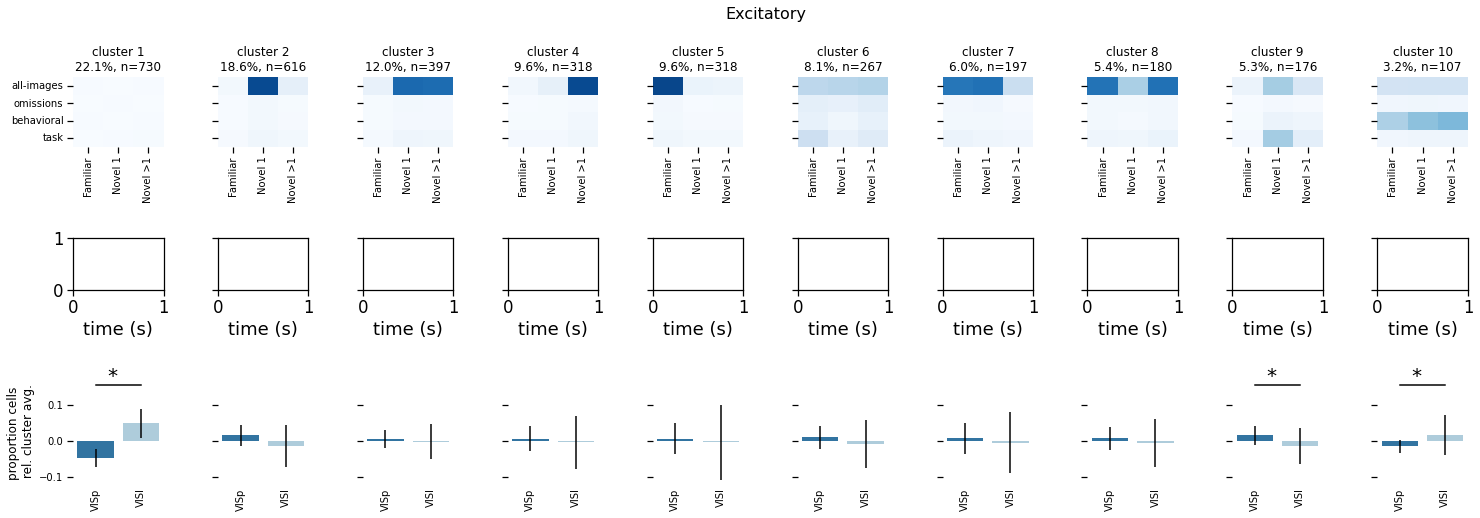

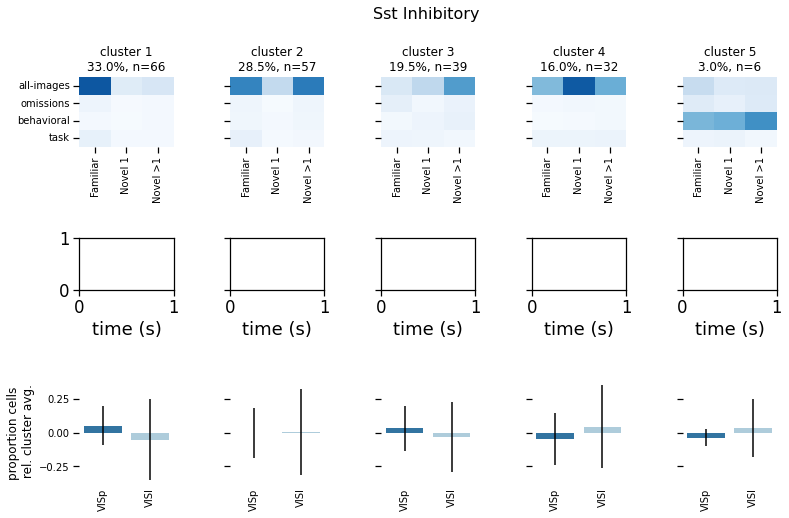

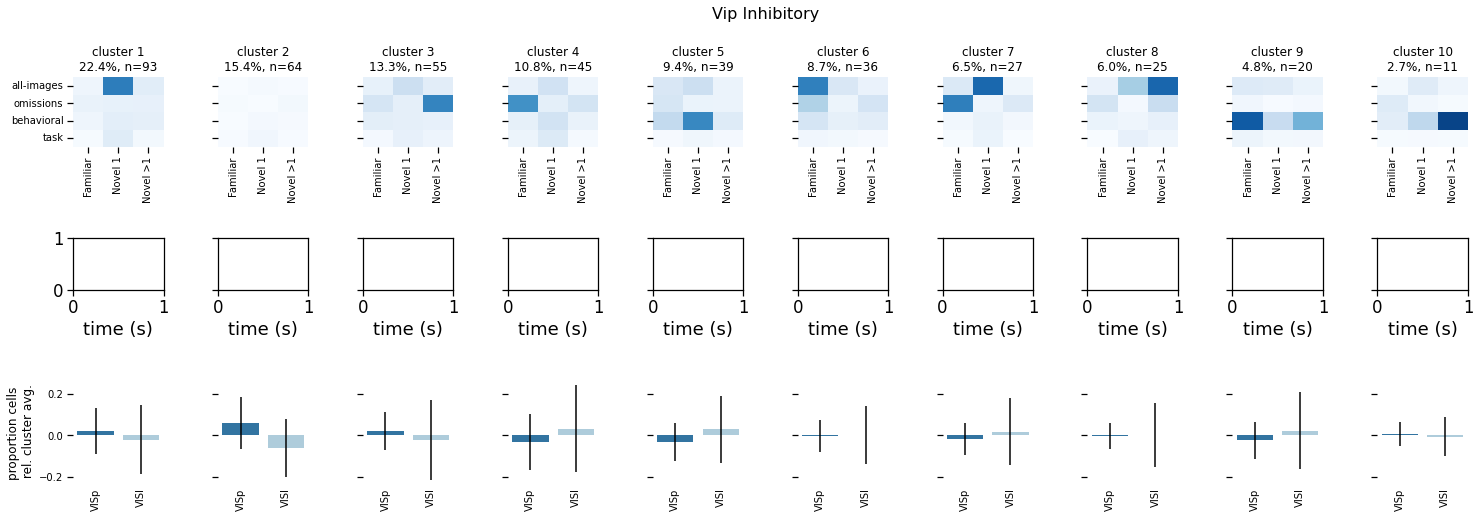

In [297]:
# this plot doesnt work without multi_session_df

for cre_line in cre_lines:
    vba_clust.plot_clusters_stats_pop_avg_rows(df_meta, feature_matrix, multi_session_df=None, cre_line = cre_line,
                                     columns_to_groupby=['targeted_structure'], change=False, omitted=True,
                                     sort_order=None, save_dir=save_dir, folder='cluster_proportions_plot/areas', suffix='', alpha=0.05)


In [205]:
# # shuffled cluster sizes means
# shuffle_type_cluster_sizes = threshold_cluster_sizes[threshold]
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
        
#         table = pd.DataFrame(shuffle_type_cluster_sizes[shuffle_type][cre_line]).mean(axis=0)
#         # original cluster sizes
#         table2 = cre_original_cluster_sizes[cre_line]

#         # convert to shuffled proportions
#         table_proportions = table/table.sum()
#         # adjust to original number of cells
#         table = table_proportions*table2.sum()

#         out =chisquare(table.values, table2.values)
#         print(shuffle_type, cre_line, out)


In [206]:
# # shuffled cluster sizes means
# shuffle_type_cluster_sizes = threshold_cluster_sizes[threshold]
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
        
#         table = pd.DataFrame(shuffle_type_cluster_sizes[shuffle_type][cre_line]).mean(axis=0)
#         # original cluster sizes
#         table2 = cre_original_cluster_sizes[cre_line]

#         # convert to shuffled proportions
#         table_proportions = table/table.sum()
#         # adjust to original number of cells
#         #table = table_proportions*table2.sum()
#         print(table.sum(), table2.sum())
#         try:
#             out =chisquare(table.values, table2.values)
#             print(shuffle_type, cre_line, out)
#         except:
#             print('not matched')
